In [23]:
%load_ext autoreload
%autoreload 2

import pandas as pd

# Set display options to show more columns and wider output
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Don't truncate column contents

from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Tasks
## Backlog
- Remove \n signs
- Batch messages processing
- Check how much each messege connected to another
## Done
- Pass for each event the last timestemp an update apeared
- Pass the OpenAI client json that is loaded with data the the promot will use
- Add total cost for OpenAI client
- Create organizations list with translation to he and en

# אפיון בסיסי
- להתריע על אירועים לפי גזרה מוגדרת שמעניינת אותנו
- לא כל אירוע שמתקיים בארץ ואפילו בצפון מעניין אותנו
- צריך להגדיר בצורה מדויקת מה מעניין ומה לא

# Read Messeges

In [8]:
import json
import pandas as pd

# Specify the file path
file_path = "telegram_messages.json"  # Replace with the actual file path if different

# Read the JSON file
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Convert the JSON data to a Pandas DataFrame
df = pd.json_normalize(data)

# Display the DataFrame
df.head()

,channel,message_id,timestamp,message,media,metadata.sender_id,metadata.message_type
0,From_hebron,270263,2024-10-13 19:32:55,♦️إعلام العدو يتحدث عن حدث أمني صعب.,[],-1001478404564,Message
1,From_hebron,270262,2024-10-13 19:32:20,♦️ يسرائيل للو تسنزورا: إصابة قاعدة تدريب غولا...,[],-1001478404564,Message
2,From_hebron,270261,2024-10-13 19:31:11,محكمة الاحتلال تُمدد الحكم على الأسير سليم الر...,"[{'media_type': 'MessageMediaPhoto', 'media_id...",-1001478404564,Message
3,From_hebron,270260,2024-10-13 19:29:24,♦️المتحدثة باسم الشرطة الصهيونيه : المتظاهرون ...,"[{'media_type': 'MessageMediaDocument', 'media...",-1001478404564,Message
4,From_hebron,270259,2024-10-13 19:29:07,♦️ القسام يعلن تفجير عين نفق في قوة اسرائيلية ...,[],-1001478404564,Message


# Translate Messages

In [73]:
import pandas as pd
from typing import Optional, Dict, List
from pydantic import BaseModel
from openai_client import OpenAIClient
from tqdm import tqdm

class TranslationResponse(BaseModel):
    """Response model for translations."""
    hebrew: str
    english: str

class NERResponse(BaseModel):
    """Response model for Named Entity Recognition (NER)."""
    locations: List[str]
    people: List[str]
    organizations: List[str]

class MessageTranslator:
    """Processor class to handle Telegram message translation."""
    
    def __init__(self, client: OpenAIClient):
        self.client = client

    def translate_message(self, message: str) -> Optional[TranslationResponse]:
        """Translate a Telegram message into both Hebrew and English."""
        system_message = """
            Act as a highly accurate translator. Your task is to take an Arabic message from a Telegram group and translate it into both 
            Hebrew and English.

            Ensure that:
            
            - All emojis and decorative symbols (such as bullets, arrows, or icons) are removed from the original message before translation.
            - The translations are precise and maintain the original meaning, tone, and nuance, so the user fully understands both the context 
              and sentiment.
            - Military, organizational, or specific terminology (e.g., names of groups, military actions) should be translated consistently 
              without alteration or substitution.
            - Prioritize clarity and natural phrasing in both Hebrew and English, avoiding overly literal translations, while maintaining 
              fidelity to the original message.
            - Retain punctuation and formatting (such as parentheses) accurately to ensure readability in both languages.
            - Maintain urgency and emotional tone (e.g., in reports of military strikes, martyrdom) in a way that sounds natural and fluent.
        """
        
        response = self.client.chat(
            system_message=system_message,
            user_message=message,
            response_format=TranslationResponse
        )

        return response

class NERProcessor:
    """Processor class to handle Named Entity Recognition (NER) on Telegram messages."""
    
    def __init__(self, client: OpenAIClient):
        self.client = client

    def extract_entities(self, message: str) -> Optional[NERResponse]:
        """Perform NER to extract locations, people, and organizations from the message."""
        system_message = """
            Act as an entity recognition system. Your task is to extract the following entities from the provided Arabic Telegram message:
            
            - Locations: Geographical places mentioned in the message.
            - People: Names of individuals mentioned.
            - Organizations: Names of groups, companies, or military organizations mentioned.

            Ensure that:
            - You return only the names without extra context or symbols.
            - If no entities are found, return empty lists for each category.
        """
        
        response = self.client.chat(
            system_message=system_message,
            user_message=message,
            response_format=NERResponse
        )

        return response

class MainProcessor:
    """Class to manage the full pipeline: reading messages, translating, extracting entities, and updating DataFrame."""
    
    def __init__(self, translator: MessageTranslator, ner_processor: NERProcessor, df: pd.DataFrame):
        self.translator = translator
        self.ner_processor = ner_processor
        self.df = df.copy()  # Avoid modifying the original df

        # Prepare new columns for translations and entity recognition
        self.df['hebrew_translation'] = None
        self.df['english_translation'] = None
        self.df['locations'] = None
        self.df['people'] = None
        self.df['organizations'] = None

    def run(self) -> pd.DataFrame:
        """Run the full pipeline, translating each message, extracting entities, and returning an updated DataFrame."""
        for index, row in tqdm(self.df.iterrows(), total=len(self.df), desc="Processing messages"):
            message = row['message']
            
            # Perform translation
            translation = self.translator.translate_message(message)
            if translation:
                self.df.at[index, 'hebrew_translation'] = translation.hebrew
                self.df.at[index, 'english_translation'] = translation.english
            else:
                print(f"No translation found for message_id {row['message_id']}.")

            # Perform NER
            ner_data = self.ner_processor.extract_entities(translation.english)
            if ner_data:
                self.df.at[index, 'locations'] = ", ".join(ner_data.locations)
                self.df.at[index, 'people'] = ", ".join(ner_data.people)
                self.df.at[index, 'organizations'] = ", ".join(ner_data.organizations)
            else:
                print(f"No NER data found for message_id {row['message_id']}.")

        # Return the updated DataFrame with translations and NER data
        return self.df

if __name__ == "__main__":
    # Specify the file path
    file_path = "telegram_messages.json"  # Replace with the actual file path if different
    
    # Read the JSON file
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    # Convert the JSON data to a Pandas DataFrame
    df = pd.json_normalize(data)

    # Initialize the OpenAI client, translators, and processors
    openai_client = OpenAIClient()
    message_translator = MessageTranslator(openai_client)
    ner_processor = NERProcessor(openai_client)
    main_processor = MainProcessor(message_translator, ner_processor, df)

    # Run the pipeline and get the updated DataFrame
    updated_df = main_processor.run()

    # Print the total costs of OpenAI calls
    openai_client.print_total_costs()

    # Display the updated DataFrame with translations and entity recognition
    display(updated_df[['message', 'hebrew_translation', 'english_translation', 'locations', 'people', 'organizations']])


Using closest match for encoding: 'gpt-4o' for input model 'gpt-4o-2024-08-06'
Resolved model for encoding: 'gpt-4o'
Using pricing model: 'gpt-4o-2024-08-06'


Processing messages: 100%|███████████████████████████████████████| 25/25 [01:15<00:00,  3.03s/it]

Total prompt cost: $0.021985
Total completion cost: $0.020620
Overall total cost: $0.042605


,message,hebrew_translation,english_translation,locations,people,organizations
0,♦️إعلام العدو يتحدث عن حدث أمني صعب.,תקשורת האויב מדברת על אירוע ביטחוני קשה.,Enemy media talks about a serious security incident.,,,
1,♦️ يسرائيل للو تسنزورا: إصابة قاعدة تدريب غولاني \nبطائرة\n مسيرة تابعة للحزب في عكا قبل قليل,ישראל לא תצנזור: פגיעה בבסיס אימונים של גולני ברחפן של החזבאללה בעכו לפני זמן קצר.,Israel will not censor: Golani training base hit by a Hezbollah drone in Acre recently.,Acre,,"Israel, Golani, Hezbollah"
2,محكمة الاحتلال تُمدد الحكم على الأسير سليم الرجوب من سكان حي كريسة بمدينة دورا للمرة الثالثة على التوالي لمدة ستة أشهر إضافية.,"בית המשפט של הכיבוש מאריך את פסק הדין על האסיר סלים רג'וב, תושב שכונת קריסה בעיר דורה, בפעם השלישית ברציפות למשך שישה חודשים נוספים.","The occupation court extends the sentence of detainee Salim Rajoub, a resident of the Karisah neighborhood in the city of Dura, for the third consecutive time for an additional six months.","Karisah, Dura",Salim Rajoub,
3,♦️المتحدثة باسم الشرطة الصهيونيه : المتظاهرون ضد الحكومة عرضوا حياة ضباط الشرطة للخطر أمس عندما تعمدوا إشعال حريق كبير على بعد بوصات منهم.,דוברת המשטרה הציונית: המפגינים נגד הממשלה סיכנו את חיי קציני המשטרה אתמול כאשר בכוונה תחילה הציתו שריפה גדולה במרחק של אינצ'ים מהם.,The spokesperson for the Zionist police: The demonstrators against the government endangered the lives of police officers yesterday when they deliberately ignited a large fire just inches away from them.,,,Zionist police
4,♦️ القسام يعلن تفجير عين نفق في قوة اسرائيلية راجلة شمال مدينة بيت لاهيا شمال القطاع,הקסאם מכריז על פיצוץ פתח מנהרה בכוח ישראלי רגלי בצפון העיר בית להיה בצפון הרצועה,Al-Qassam announces the detonation of a tunnel entrance against an Israeli foot patrol north of Beit Lahia in the northern part of the Gaza Strip,"Beit Lahia, Gaza Strip",,Al-Qassam
5,🛑اعتراض الطائرة بدون طيار في سماء كريات قبل قليل,יירוט כלי טיס בלתי מאויש מעל קריית לפני זמן קצר,Interception of an unmanned aerial vehicle over Kiryat a short while ago,Kiryat,,
6,"🚫🟠🟠 🟢 كتائب القسام تستهدف ناقلة جند صهيونية بقذيفة ""تاندوم"" شمال مدينة بيت لاهيا شمال القطاع","גדודי עז א-דין אל-קסאם תוקפים רכב משוריין ישראלי עם רקטה ""טאנדם"" בצפון בית לייה בצפון הרצועה",Al-Qassam Brigades target a Zionist armored vehicle with a 'Tandem' missile north of Beit Lahia in the northern Gaza Strip,"Beit Lahia, northern Gaza Strip",,Al-Qassam Brigades
7,♦️بالفيديو | كلمة سماحة الأمين العام الشهيد الي ( المجاهدين خلال إحدى المناورات العسكرية,"בסרטון | נאום של מזכ""ל הקדוש, השהיד, לאחים הלוחמים במהלך אחד התרגילים הצבאיים","In the video | Speech by the Sacred Secretary-General, the martyr, to the mujahideen during one of the military exercises",,,
8,♦️عاجل| حزب الله يشن هجوماً مركباً بالطائرات المسيّرة والصواريخ على شمال فلسطين المحتلة.,דחוף| חזבאללה מבצע התקפה משולבת באמצעות רחפנים וטילים על צפון פלסטין הכבושה.,Urgent| Hezbollah launches a combined attack with drones and missiles on northern occupied Palestine.,northern occupied Palestine,,Hezbollah
9,♦️التقارير الأولية دون رقابة: \nإصابة مستوطن نتيجة سقوط شظايا في منطقة كريات شمونة.,דיווחים ראשוניים ללא צנזורה: נפגע מתנחל כתוצאה מנפילת רסיסים באזור קריית שמונה.,Initial uncensored reports: A settler was injured due to falling shrapnel in the Kiryat Shmona area.,Kiryat Shmona,,


# Cost

# Event Management

In [93]:
updated_df.columns

Index(['channel', 'message_id', 'timestamp', 'message', 'media',
       'metadata.sender_id', 'metadata.message_type', 'hebrew_translation',
       'english_translation', 'locations', 'people', 'organizations'],
      dtype='object')

In [95]:
import pandas as pd
from datetime import datetime, timedelta
from pydantic import BaseModel
from typing import List, Optional
from openai_client import OpenAIClient

class EventUpdateResponse(BaseModel):
    """Response model for event updates."""
    event_type: str
    event_name: str

class TelegramMessageProcessor:
    """Processor class to handle Telegram message classification and updates."""
    
    def __init__(self, client: OpenAIClient):
        self.client = client
        self.active_events = []  # List to track currently active events

    def classify_message(self, message: pd.Series, current_events: List[dict]) -> Optional[EventUpdateResponse]:
        """Classify a Telegram message into an event type and generate an event name."""
        
        # Create a formatted string to pass the current event names and last update timestamps
        event_info = "\n".join([f"Event: {event['name']} (Last update: {event['last_update']})" for event in current_events])
        
        system_message = f"""
You are an event classifier. Based on the following ongoing events and their last update dates, classify the new message into one of 
these events or suggest a new event name.

Ongoing events:
{event_info}

Important Note: If the event mentioned in the message seems to refer to something that happened after a long time or a separate instance
of a similar event, classify it as a new event.

Message:
        """
        user_message = f"{message['english_translation']}, which sent in: {message['timestamp']}"
        
        # print("------------------------------------------------------------------------------------")
        # print(system_message)
        # print(user_message)

        response = self.client.chat(
            system_message=system_message,
            user_message=user_message,
            response_format=EventUpdateResponse
        )

        return response
    
    def update_event(self, classification: EventUpdateResponse, message: str, timestamp: datetime) -> str:
        """Update an existing event with new information, or create a new event."""
        event_name = classification.event_name or f"{classification.event_type} Event {len(self.active_events) + 1}"
        event_exists = False

        for event in self.active_events:
            # Check if the message belongs to this event by name
            if event['name'] == event_name:
                # Update existing event
                event['messages'].append(message)
                event['timestamps'].append(timestamp)
                event['last_update'] = timestamp
                event_exists = True
                print(f"Message added to existing event: {event_name}")
                break

        if not event_exists:
            # Create a new event if not found
            new_event = {
                'type': classification.event_type,
                'name': event_name,
                'messages': [message],
                'timestamps': [timestamp],
                'first_report': timestamp,
                'last_update': timestamp
            }
            self.active_events.append(new_event)
            print(f"New event created: {event_name}")

        print(f"Message: {message['english_translation']}, Event Type: {classification.event_type}\n")
        return event_name
    
    def process_new_message(self, message: pd.Series) -> str:
        """Process a new incoming Telegram message."""
        current_event_names = [{'name': event['name'], 'last_update': event['last_update']} for event in self.active_events]
        classification = self.classify_message(message, current_event_names)
        
        if classification:
            event_name = self.update_event(classification, message, timestamp)
            return event_name
        else:
            print("Message could not be classified.")
            return "Unclassified"

    def get_active_events(self):
        """Get the current list of active events."""
        return [{"name": event['name'], "type": event['type'], "last_update": event['last_update']} for event in self.active_events]

# Create a pandas DataFrame to store messages, timestamps, and event names
df = updated_df.copy()

# Simulating the processing of the messages
client = OpenAIClient()  # Initialize OpenAI client
processor = TelegramMessageProcessor(client)

# Process each fake message and store the event name in the DataFrame
for index, row in df.iterrows():
    event_name = processor.process_new_message(row)
    df.at[index, "event_name"] = event_name

# Display the final DataFrame with event names, messages, and timestamps
display(df[['event_name', 'english_translation', 'timestamp']].sort_values(by=['event_name', 'timestamp'], ascending=[True, True]))

# Count event messages
print(df['event_name'].value_counts())

# Print the total costs of OpenAI calls
openai_client.print_total_costs()

Using closest match for encoding: 'gpt-4o' for input model 'gpt-4o-2024-08-06'
Resolved model for encoding: 'gpt-4o'
Using pricing model: 'gpt-4o-2024-08-06'
New event created: 2024 Security Incident Discussion by Media
Message: Enemy media talks about a serious security incident., Event Type: new

New event created: 2024 Hezbollah Drone Strike in Acre
Message: Israel will not censor: Golani training base hit by a Hezbollah drone in Acre recently., Event Type: New Event

New event created: 2024 Extension of Salim Rajoub's Detention in Dura
Message: The occupation court extends the sentence of detainee Salim Rajoub, a resident of the Karisah neighborhood in the city of Dura, for the third consecutive time for an additional six months., Event Type: New Event

New event created: 2024 Protest and Fire Incident Against Government in Zionist Region
Message: The spokesperson for the Zionist police: The demonstrators against the government endangered the lives of police officers yesterday when

,event_name,message,timestamp
6,2024 Al-Qassam Brigade Missile Attack on Armored Vehicle in Beit Lahia,"🚫🟠🟠 🟢 كتائب القسام تستهدف ناقلة جند صهيونية بقذيفة ""تاندوم"" شمال مدينة بيت لاهيا شمال القطاع",2024-10-13 19:19:43
4,2024 Al-Qassam Tunnel Detonation Incident in Beit Lahia,♦️ القسام يعلن تفجير عين نفق في قوة اسرائيلية راجلة شمال مدينة بيت لاهيا شمال القطاع,2024-10-13 19:29:07
16,2024 Arrival of American THAAD System in Israel,♦️البنتاغون في إعلان رسمي: نظام الدفاع الجوي بعيد المدى ثاد التابع للجيش الأمريكي سيصل إلى إسرائيل.\n\nومن المتوقع أن يصل معها نحو 100 جندي.,2024-10-13 18:55:04
24,2024 Clashes in Tuqu' with Occupation Forces,اندلاع مواجهات بين الشبان وقوات الاحتلال في بلدة تقوع قضاء بيت لحم.,2024-10-13 18:36:50
20,2024 Drone Attack and Siren Sounding in Nahariya,♦️هجوم بلمسيرات في نهاريا و صفارات الانذار لا تزال تدوي.\n@FROM_HEBRON,2024-10-13 18:49:12
18,2024 Explosions Heard in Occupied Acre,♦️#عاجل..\n\nسماع دوي انفجارات في عكا المحتلة ..,2024-10-13 18:52:47
2,2024 Extension of Salim Rajoub's Detention in Dura,محكمة الاحتلال تُمدد الحكم على الأسير سليم الرجوب من سكان حي كريسة بمدينة دورا للمرة الثالثة على التوالي لمدة ستة أشهر إضافية.,2024-10-13 19:31:11
17,2024 Hezbollah Combined Drone and Missile Attack on Northern Occupied Palestine,♦️مسيرة اخترقت الناقورة ونهاريا و عكا والا ع مشارف حيفا,2024-10-13 18:53:02
15,2024 Hezbollah Combined Drone and Missile Attack on Northern Occupied Palestine,♦️يبدو أن الليله سوف تكون جحيم على الاحتلال \nحزب الله يضرب الكيان بكل قوه الان,2024-10-13 18:56:55
12,2024 Hezbollah Combined Drone and Missile Attack on Northern Occupied Palestine,♦️عاجل: مصادر عبرية: دوي عشرات الانفجارات تسمع في عدة مناطق شمال فلسطين المحتلة، بعد رشقة صاروخية ومسيرات من #لبنان.,2024-10-13 19:10:38


event_name
2024 Hezbollah Combined Drone and Missile Attack on Northern Occupied Palestine    4
2024 Security Alert in Upper and Western Galilee                                   2
2024 Kiryat Shmona Shrapnel Injury Incident                                        2
2024 Security Incident Discussion by Media                                         1
2024 Large Rocket Barrage from Lebanon on Northern Occupied Palestine              1
2024 Unidentified Aerial Activity Over Galilee                                     1
2024 Drone Attack and Siren Sounding in Nahariya                                   1
2024 Saraya al-Quds Missile Attack on Merkava Tank in Jabalia                      1
2024 Explosions Heard in Occupied Acre                                             1
2024 Arrival of American THAAD System in Israel                                    1
2024 Sirens Sounding Incident in Zarit                                             1
2024 Martyrdom of Singer Hamza Abu Qinas 'Abu Bilal'  

## Later, we can implement batch processing

I got stuck in implementing batch processing of multiple messages at the same time. Mainly the response format is misleading and unclear (for me, right now). I decided to return to this once we will meet a great amount of events.

Below is a pydantic objects that can support the batch processing task:

In [118]:
from pydantic import BaseModel
from typing import List, Dict, Optional
from enum import Enum
from openai_client import OpenAIClient

# Predefined event types (fixed)
class EventType(Enum):
    MILITARY_ATTACKS_STRIKES = "Military Attacks and Strikes"
    SECURITY_INCIDENTS = "Security Incidents"
    ROCKET_INTERCEPTIONS_BARRAGES = "Rocket or Drone Interceptions or Rocket Barrages or Sirens"
    CIVILIAN_CASUALTIES_CLASHES = "Civilian Casualties and Injuries and Clashes"
    DEATH_ANNOUNCEMENTS = "Death Announcements"
    POLITICAL_GOVERNMENT_UPDATES = "Political and Government Updates"
    MILITARY_MOVEMENTS_ANNOUNCEMENTS = "Military Movements or Announcements"

# Response model for event classification
class EventUpdateResponse(BaseModel):
    event_type: EventType  # Predefined event type
    event_number: Optional[int]  # Event number (if it exists)
    event_name: Optional[str]  # Optional event name for new events

# New model that includes message ID and its classification
class MessageClassification(BaseModel):
    message_id: str
    classification: EventUpdateResponse

class ClassificationResponse(BaseModel):
    classifications: List[MessageClassification]


# Creating Flow Timeline

In [119]:
import pandas as pd
from datetime import datetime, timedelta
from pydantic import BaseModel
from typing import List, Optional
from openai_client import OpenAIClient

class EventUpdateResponse(BaseModel):
    """Response model for event updates."""
    event_type: str
    event_name: str

class TelegramMessageProcessor:
    """Processor class to handle Telegram message classification and updates."""
    
    def __init__(self, client: OpenAIClient):
        self.client = client
        self.active_events = []  # List to track currently active events

    def classify_message(self, message: pd.Series, current_events: List[dict]) -> Optional[EventUpdateResponse]:
        """Classify a Telegram message into an event type and generate an event name."""
        
        # Create a formatted string to pass the current event names and last update timestamps
        event_info = "\n".join([f"Event: {event['name']} (Last update: {event['last_update']})" for event in current_events])
        
        system_message = f"""
You are an event classifier. Based on the following ongoing events and their last update dates, classify the new message into one of 
these events or suggest a new event name.

Ongoing events:
{event_info}

Important Note: If the event mentioned in the message seems to refer to something that happened after a long time or a separate instance
of a similar event, classify it as a new event.

Message:
        """
        user_message = f"{message['english_translation']}, which sent in: {message['timestamp']}"
        
        # print("------------------------------------------------------------------------------------")
        # print(system_message)
        # print(user_message)

        response = self.client.chat(
            system_message=system_message,
            user_message=user_message,
            response_format=EventUpdateResponse
        )

        return response
    
    def update_event(self, classification: EventUpdateResponse, message: str, timestamp: datetime) -> str:
        """Update an existing event with new information, or create a new event."""
        event_name = classification.event_name or f"{classification.event_type} Event {len(self.active_events) + 1}"
        event_exists = False

        for event in self.active_events:
            # Check if the message belongs to this event by name
            if event['name'] == event_name:
                # Update existing event
                event['messages'].append(message)
                event['timestamps'].append(timestamp)
                event['last_update'] = timestamp
                event_exists = True
                print(f"Message added to existing event: {event_name}")
                break

        if not event_exists:
            # Create a new event if not found
            new_event = {
                'type': classification.event_type,
                'name': event_name,
                'messages': [message],
                'timestamps': [timestamp],
                'first_report': timestamp,
                'last_update': timestamp
            }
            self.active_events.append(new_event)
            print(f"New event created: {event_name}")

        print(f"Message: {message['english_translation']}, Event Type: {classification.event_type}\n")
        return event_name
    
    def process_new_message(self, message: pd.Series) -> str:
        """Process a new incoming Telegram message."""
        current_event_names = [{'name': event['name'], 'last_update': event['last_update']} for event in self.active_events]
        classification = self.classify_message(message, current_event_names)
        
        if classification:
            event_name = self.update_event(classification, message, timestamp)
            return event_name
        else:
            print("Message could not be classified.")
            return "Unclassified"

    def get_active_events(self):
        """Get the current list of active events."""
        return [{"name": event['name'], "type": event['type'], "last_update": event['last_update']} for event in self.active_events]

# Create a pandas DataFrame to store messages, timestamps, and event names
df = updated_df.copy()

# Simulating the processing of the messages
client = OpenAIClient()  # Initialize OpenAI client
processor = TelegramMessageProcessor(client)

# Process each fake message and store the event name in the DataFrame
for index, row in df.iterrows():
    event_name = processor.process_new_message(row)
    df.at[index, "event_name"] = event_name

# Display the final DataFrame with event names, messages, and timestamps
display(df[['event_name', 'english_translation', 'timestamp']].sort_values(by=['event_name', 'timestamp'], ascending=[True, True]))

# Count event messages
print(df['event_name'].value_counts())

# Print the total costs of OpenAI calls
openai_client.print_total_costs()

Using closest match for encoding: 'gpt-4o' for input model 'gpt-4o-2024-08-06'
Resolved model for encoding: 'gpt-4o'
Using pricing model: 'gpt-4o-2024-08-06'
New event created: Alleged Security Incident October 2024
Message: Enemy media talks about a serious security incident., Event Type: New Event

New event created: Hezbollah Drone Attack October 2024
Message: Israel will not censor: Golani training base hit by a Hezbollah drone in Acre recently., Event Type: New Event

New event created: Detainee Salim Rajoub Sentence Extension October 2024
Message: The occupation court extends the sentence of detainee Salim Rajoub, a resident of the Karisah neighborhood in the city of Dura, for the third consecutive time for an additional six months., Event Type: new

New event created: Government Protest Incident October 2024
Message: The spokesperson for the Zionist police: The demonstrators against the government endangered the lives of police officers yesterday when they deliberately ignited a

,event_name,english_translation,timestamp
19,Al-Qassam Tandem Missile Attack on Armored Vehicle October 2024,Saraya al-Quds: We targeted a Zionist Merkava tank with a Tandem missile in the al-Qasasib area near the Aisha Mosque in the center of Jabalia refugee camp in northern Gaza Strip.,2024-10-13 18:50:08
6,Al-Qassam Tandem Missile Attack on Armored Vehicle October 2024,Al-Qassam Brigades target a Zionist armored vehicle with a 'Tandem' missile north of Beit Lahia in the northern Gaza Strip,2024-10-13 19:19:43
4,Al-Qassam Tunnel Explosion Against Israeli Patrol October 2024,Al-Qassam announces the detonation of a tunnel entrance against an Israeli foot patrol north of Beit Lahia in the northern part of the Gaza Strip,2024-10-13 19:29:07
0,Alleged Security Incident October 2024,Enemy media talks about a serious security incident.,2024-10-13 19:32:55
24,Clashes in Tuqu' Bethlehem District October 2024,Clashes erupt between young men and occupation forces in the town of Tuqu' in the Bethlehem district.,2024-10-13 18:36:50
16,Deployment of American THAAD Air Defense System in Israel October 2024,The Pentagon in an official announcement: The American Army's long-range air defense system THAAD will arrive in Israel.\n\nApproximately 100 soldiers are expected to arrive with it.,2024-10-13 18:55:04
2,Detainee Salim Rajoub Sentence Extension October 2024,"The occupation court extends the sentence of detainee Salim Rajoub, a resident of the Karisah neighborhood in the city of Dura, for the third consecutive time for an additional six months.",2024-10-13 19:31:11
18,Explosions in Occupied Acre October 2024,#Urgent..\nSounds of explosions heard in occupied Acre..,2024-10-13 18:52:47
23,Galilee Aerial Activity October 2024,Urgent: Sirens are once again sounding in the occupied Galilee.,2024-10-13 18:37:40
21,Galilee Aerial Activity October 2024,From the skies of Galilee a short while ago...,2024-10-13 18:47:26


event_name
Galilee Aerial Activity October 2024                                         2
Al-Qassam Tandem Missile Attack on Armored Vehicle October 2024              2
Hezbollah Combined Drone and Missile Attack October 2024                     2
Kiryat Shmona Area Incident October 2024                                     2
Hezbollah Drone Attack October 2024                                          2
Northern Palestine Rocket and Drone Barrage October 2024                     2
Alleged Security Incident October 2024                                       1
Zarit Border Incident October 2024                                           1
Lebanon Rocket Barrage October 2024                                          1
Nahariya Drone Attack October 2024                                           1
Explosions in Occupied Acre October 2024                                     1
Deployment of American THAAD Air Defense System in Israel October 2024       1
Martyrdom of Singer Hamza Abu Qinas Octob

In [121]:
df.columns

Index(['channel', 'message_id', 'timestamp', 'message', 'media',
       'metadata.sender_id', 'metadata.message_type', 'hebrew_translation',
       'english_translation', 'locations', 'people', 'organizations',
       'event_name'],
      dtype='object')

In [128]:
display(df.sort_values(by=['event_name', 'timestamp'], ascending=[True, True]))

,channel,message_id,timestamp,message,media,metadata.sender_id,metadata.message_type,hebrew_translation,english_translation,locations,people,organizations,event_name
47,From_hebron,270903,2024-10-14 22:08:10,📍🇵🇸 مصادر صحفية :\n\n\nعبر نتساريم وصول شاحنات مساعدات وبضائع من شارع صلاح الدين الآن لوسط القطاع\n\n🚨🚨🚨,[],-1001478404564,Message,מקורות תקשורת: \n\nעבר נטסריים הגעת משאיות סיוע וסחורות מרחוב סלאח א-דין עכשיו למרכז הרצועה.,"Media sources: \n\nVia Netzarim, the arrival of aid and goods trucks from Salah al-Din Street to the central region of the strip now.","Netzarim, Salah al-Din Street",,,Aid and Goods Arrival in Gaza October 2024
30,From_hebron,270920,2024-10-14 22:37:30,📍4شهداء ومصابون في استهداف منزل يعود لعائلة السيد في محيط مسجد الهندي بمنطقة الفالوجا بمخيم جباليا شمال قطاع غزة,[],-1001478404564,Message,4 הרוגים ופצועים במתקפה על בית משפחת אלסייד בסביבת מסגד אל-הינדי באזור אלפאלוג'ה במחנה הפליטים ג'באליה בצפון רצועת עזה.,"4 martyrs and injured in a strike targeting a house belonging to the Al-Sayed family near the Al-Hindi Mosque in the Al-Falouja area of Jabalia camp, northern Gaza Strip.","Al-Falouja, Jabalia camp, northern Gaza Strip",Al-Sayed,,Airstrikes in Gaza October 2024
23,From_hebron,270927,2024-10-14 22:46:04,🤔#فيديو طفل يودع شقيقه الذي استشهد في قصف صهيوني لعائلة الداية بحي الصبرة جنوب مدينة غزة، قبل عدة أيام.\n\n#غــ𓂆ــزة 🇵🇸,"[{'media_type': 'MessageMediaDocument', 'media_id': 270927}]",-1001478404564,Message,"וידאו של ילד שנפרד מאחיו שנהרג במתקפה ציונית על משפחת הדאיה בשכונת הסברה בדרום העיר עזה, לפני מספר ימים.","A video of a child bidding farewell to his brother who was martyred in a Zionist attack on the Dayeh family in the Sabra neighborhood in south Gaza City, a few days ago.","Sabra, Gaza City",,Dayeh,Airstrikes in Gaza October 2024
14,From_hebron,270938,2024-10-14 23:15:33,✔️🟠🟠 تحليق لطيران الاحتلال الحربي في أجواء خانيونس جنوب قطاع غزة,[],-1001478404564,Message,טיסות של מטוסי הקרב של צבא הכיבוש בשמי ח'אן יונס בדרום רצועת עזה,Flights of the occupation's warplanes over Khan Yunis in the southern Gaza Strip,"Khan Yunis, Gaza Strip",,,Airstrikes in Gaza October 2024
13,From_hebron,270939,2024-10-14 23:33:37,📍شاب يفجع باستشهاد نجله في قصف الاحتلال على مدينة غزة,"[{'media_type': 'MessageMediaDocument', 'media_id': 270939}]",-1001478404564,Message,"צעיר מוכה יגון על נפילת בנו בהפצצת צה""ל על העיר עזה",A young man is devastated by the martyrdom of his son in the Israeli occupation's bombing of Gaza City.,Gaza City,,Israeli occupation,Airstrikes in Gaza October 2024
28,From_hebron,270922,2024-10-14 22:40:28,♦️عاجل | الوكالة الوطنية للإعلام في لبنان: غارتان إسرائيليتان على بلدتي الخيام والطيبة في مرجعيون,[],-1001478404564,Message,דחוף | סוכנות הידיעות הלאומית בלבנון: שתי תקיפות ישראליות על העיירות אל-ח'יאם ואל-טייבה במרג'עיון,Urgent | The National News Agency in Lebanon: Two Israeli airstrikes on the towns of Al-Khiyam and Al-Taybeh in Marjayoun,"Al-Khiyam, Al-Taybeh, Marjayoun, Lebanon",,"The National News Agency, Israeli",Airstrikes in Marjayoun October 2024
53,From_hebron,270897,2024-10-14 22:01:22,💎🟥طيران الاحتلال يشن غارات متتالية على بلدتي الطيبة وكفرشوبا وسهل الخيام وتل دبين في جنوب لبنان.,[],-1001478404564,Message,"חיל האוויר של הכיבוש מנהל התקפות אוויריות עוקבות על העיירות א-טייבה וכפר שובא, במישור אל-ח'יאם ותל דבין בדרום לבנון.","The occupation's air force is conducting consecutive airstrikes on the towns of Taybeh and Kafr Shuba, as well as the Al-Khiam plain and Tel Debin in southern Lebanon.","Taybeh, Kafr Shuba, Al-Khiam plain, Tel Debin, southern Lebanon",,,Airstrikes in Southern Lebanon October 2024
25,From_hebron,270925,2024-10-14 22:43:55,📍ارتفاع حصيلة ضحايا العدوان الإسرائيلي على لبنان إلى 2309 شهيد 💔,[],-1001478404564,Message,עלייה במספר הנפגעים מהתוקפנות הישראלית על לבנון ל-2309 הרוגים.,The death toll from the Israeli aggression on Lebanon has risen to 2309 martyrs.,Lebanon,,,Airstrikes in Southern Lebanon October 2024
16,From_hebron,270936,2024-10-14 23:05:53,"📍جيش الاحتلال يعلن في 

In [133]:
import pandas as pd
from typing import Optional, Dict, List
from pydantic import BaseModel
from openai_client import OpenAIClient
from tqdm import tqdm

class TranslationResponse(BaseModel):
    """Response model for translations."""
    hebrew: str
    english: str

class MessageTranslator:
    """Processor class to handle Telegram message translation."""
    
    def __init__(self, client: OpenAIClient):
        self.client = client

    def translate_message(self, message: str) -> Optional[TranslationResponse]:
        """Translate a Telegram message into both Hebrew and English."""
        system_message = """
            Act as a highly accurate translator. Your task is to take an Arabic message from a Telegram group and translate it into both 
            Hebrew and English.

            Ensure that:
            
            - All emojis and decorative symbols (such as bullets, arrows, or icons) are removed from the original message before translation.
            - The translations are precise and maintain the original meaning, tone, and nuance, so the user fully understands both the context 
              and sentiment.
            - Military, organizational, or specific terminology (e.g., names of groups, military actions) should be translated consistently 
              without alteration or substitution.
            - Prioritize clarity and natural phrasing in both Hebrew and English, avoiding overly literal translations, while maintaining 
              fidelity to the original message.
            - Retain punctuation and formatting (such as parentheses) accurately to ensure readability in both languages.
            - Maintain urgency and emotional tone (e.g., in reports of military strikes, martyrdom) in a way that sounds natural and fluent.
        """
        
        response = self.client.chat(
            system_message=system_message,
            user_message=message,
            response_format=TranslationResponse,
            max_completion_tokens=3000
        )

        return response

class NERResponse(BaseModel):
    """Response model for Named Entity Recognition (NER)."""
    countries: List[str]
    locations: List[str]
    people: List[str]
    organizations: List[str]
    ad: bool
    
class NERProcessor:
    """Processor class to handle Named Entity Recognition (NER) on Telegram messages."""
    
    def __init__(self, client: OpenAIClient):
        self.client = client

    def extract_entities(self, message: str) -> Optional[NERResponse]:
        """Perform NER to extract locations, people, and organizations from the message."""
        system_message = """
            Act as an entity recognition system. Your task is to extract the following entities from the provided Arabic Telegram message:
            
            - Countries: Countries mentioned in the message.
            - Locations: Geographical places mentioned in the message.
            - People: Names of individuals mentioned.
            - Organizations: Names of groups, companies, or military organizations mentioned.
            - Ad: True when there is an ad for a Telegram chanel or to product.

            Ensure that:
            - You return only the names without extra context or symbols.
            - If no entities are found, return empty lists for each category.
        """
        
        response = self.client.chat(
            system_message=system_message,
            user_message=message,
            response_format=NERResponse,
            max_completion_tokens=3000
        )

        return response

class MainProcessor:
    """Class to manage the full pipeline: reading messages, translating, extracting entities, and updating DataFrame."""
    
    def __init__(self, translator: MessageTranslator, ner_processor: NERProcessor, df: pd.DataFrame):
        self.translator = translator
        self.ner_processor = ner_processor
        self.df = df.copy()  # Avoid modifying the original df

        # Prepare new columns for translations and entity recognition
        self.df['hebrew_translation'] = None
        self.df['english_translation'] = None
        self.df['locations'] = None
        self.df['people'] = None
        self.df['organizations'] = None

    def run(self) -> pd.DataFrame:
        """Run the full pipeline, translating each message, extracting entities, and returning an updated DataFrame."""
        for index, row in tqdm(self.df.iterrows(), total=len(self.df), desc="Processing messages"):
            message = row['message']
            
            # Perform translation
            translation = self.translator.translate_message(message)
            if translation:
                self.df.at[index, 'hebrew_translation'] = translation.hebrew
                self.df.at[index, 'english_translation'] = translation.english
            else:
                print(f"No translation found for message_id {row['message_id']}.")

            # Perform NER
            ner_data = self.ner_processor.extract_entities(translation.english)
            if ner_data:
                self.df.at[index, 'countries'] = ", ".join(ner_data.countries)
                self.df.at[index, 'locations'] = ", ".join(ner_data.locations)
                self.df.at[index, 'people'] = ", ".join(ner_data.people)
                self.df.at[index, 'organizations'] = ", ".join(ner_data.organizations)
                self.df.at[index, 'ad'] = self.df.at[index, 'ad'] = float(ner_data.ad) if ner_data.ad != 'False' else np.nan
            else:
                print(f"No NER data found for message_id {row['message_id']}.")

        # Return the updated DataFrame with translations and NER data
        return self.df

if __name__ == "__main__":
    # Specify the file path
    file_path = "telegram_messages_v2.json"
    
    # Read the JSON file
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    # Convert the JSON data to a Pandas DataFrame
    df = pd.json_normalize(data).head(15)

    # Initialize the OpenAI client, translators, and processors
    openai_client = OpenAIClient()
    message_translator = MessageTranslator(openai_client)
    ner_processor = NERProcessor(openai_client)
    main_processor = MainProcessor(message_translator, ner_processor, df)

    # Run the pipeline and get the updated DataFrame
    updated_df = main_processor.run()

    # Print the total costs of OpenAI calls
    openai_client.print_total_costs()

    # Display the updated DataFrame with translations and entity recognition
    display(updated_df[['message', 'hebrew_translation', 'english_translation', 'countries' ,'locations', 'people', 'organizations', 'ad']])


Using closest match for encoding: 'gpt-4o' for input model 'gpt-4o-2024-08-06'
Resolved model for encoding: 'gpt-4o'
Using pricing model: 'gpt-4o-2024-08-06'


Processing messages:   0%|                                                | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_17515/212580214.py:120: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.df.at[index, 'ad'] = ner_data.ad
Processing messages: 100%|███████████████████████████████████████| 15/15 [01:08<00:00,  4.57s/it]


Total prompt cost: $0.015572
Total completion cost: $0.018770
Overall total cost: $0.034342


KeyError: "['event_update', 'type_of_action'] not in index"

In [134]:
display(updated_df[['message', 'hebrew_translation', 'english_translation', 'countries' ,'locations', 'people', 'organizations', 'ad']])

,message,hebrew_translation,english_translation,countries,locations,people,organizations,ad
0,📍جيش الاحتلال يعلن مقتل 5 جنود، وإصابة 125 جندياً بينهم 17 بحالة حرجة، في مختلف جبهات القتال خلال الـ24 ساعة الماضية.,"צבא הכיבוש מודיע על הריגתם של 5 חיילים ופציעתם של 125 חיילים, מתוכם 17 במצב קשה, בחזיתות הלחימה השונות במהלך 24 השעות האחרונות.","The occupation army announces the killing of 5 soldiers and the injury of 125 soldiers, including 17 in critical condition, on various battlefronts during the past 24 hours.",,,,,False
1,📍#‏عاجل واشنطن بوست:\nنتنياهو يبلغ واشنطن أن إسرائيل ستستهدف مواقع عسكرية إيرانية وليس منشآت نووية أو حقول نفط,ראש הממשלה נתניהו מודיע לוושינגטון שישראל תכוון למטרות צבאיות איראניות ולא למתקני גרעין או שדות נפט.,Prime Minister Netanyahu informs Washington that Israel will target Iranian military sites and not nuclear facilities or oil fields.,"Israel, Iran",,Netanyahu,Washington,False
2,📍#عاجل: جيش الاحتلال يزرع براميل متفجرة في أحياء بالفالوجا غرب مخيم جباليا شمال غزة لتفجير منازل الأهالي,"#דחוף: צבא הכיבוש מניח חביות נפץ בשכונות בפלוג'ה, מערב מחנה ג'בליה בצפון עזה, כדי לפוצץ בתי התושבים.","#Urgent: The occupation army is planting explosive barrels in neighborhoods in Falouja, west of Jabalia camp in northern Gaza, to detonate residents' homes.",Gaza,"Falouja, Jabalia camp",,,False
3,📍#عاجل مصادر للجزيرة: الاحتلال يطلق النار على كل من يحاول التحرك في أحياء جباليا البلد والنزلة وبيت لاهيا وبيت حانون,"מקורות לאל-ג'זירה: הכיבוש יורה על כל מי שמנסה לנוע בשכונות ג'בליה אל-בלד, אנ-נזלה, בית לאהיה ובית חאנון.","Sources to Al-Jazeera: The occupation opens fire on anyone attempting to move in the neighborhoods of Jabalia Al-Balad, An-Nazla, Beit Lahia, and Beit Hanoun.",,"Jabalia Al-Balad, An-Nazla, Beit Lahia, Beit Hanoun",,Al-Jazeera,False
4,🔴منذ ساعة من الآن وحتى اللحظة.. اشتباكات عنيفة جدا ومن نقطة صفر بين المقاومة وقوات الاحتلال في مخيم جباليا..\n\n🔥🔥🔥🔥🔥,"נכון לשעה האחרונה ועד לרגע זה, ישנם עימותים עזים מאוד ומנקודת אפס בין ההתנגדות לכוחות הכיבוש במחנה הפליטים ג'בליה.","For the past hour and up until now, there have been very intense clashes at point-blank range between the resistance and occupation forces in the Jabalia refugee camp.",,Jabalia refugee camp,,,False
5,📍أحد أفراد طواقم الإسعاف يتفاجأ باستشهاد شقيقه أثناء عمله في إسعاف جرحى بقصف الاحتلال على الشيخ رضوان بمدينة غزة,"אחד מאנשי צוות האמבולנס הופתע מהידיעה על נפילת אחיו כשהיה בתפקיד וסיפק סיוע לפצועים כתוצאה מהפצצת צה""ל בשייח' רדואן שבעיר עזה.","A member of the ambulance crew was surprised by the news of his brother's martyrdom while he was on duty providing aid to the injured following the Israeli bombing in Sheikh Radwan, Gaza City.",Israel,"Sheikh Radwan, Gaza City",,,False
6,📍800 متر تحت الأرض\nمراسل القناة 14 العبرية من داخل أحد الأنفاق الكبيرة لقوة الرضوان في المنطقة الحدودية مع #لبنان,800 מטר מתחת לאדמה כתב ערוץ 14 העברי מתוך אחד המנהרות הגדולות של כוח רדואן באזור הגבול עם לבנון,800 meters underground Channel 14 Hebrew correspondent from within one of the large tunnels of the Radwan force in the border area with Lebanon,Lebanon,,,Channel 14,False
7,🤔طيران العدو الصهيوني يشن غارة استهدفت بلدة القصيبة في جنوب لبنان\n\n🤔طيران العدو يشن سلسلة غارات استهدفت بلدة دير سريان في جنوب لبنان\n\n🤔طيران العدو يشن غارة استهدفت بلدة حبوش قضاء النبطية في جنوب لبنان,מטוסי האויב הציוני תקפו יעד בעיירה אל-קוסייבה בדרום לבנון\n\nמטוסי האויב תקפו סדרת יעדים בעיירה דיר סריאן בדרום לבנון\n\nמטוסי האויב תקפו יעד בעיירה חבוש במחוז נבטיה בדרום לבנון,Zionist enemy aircraft carried out an airstrike targeting the town of Al-Qusaybah in southern Lebanon\n\nEnemy aircraft carried out a series of airstrikes targeting the town of Deir Siryan in southern Lebanon\n\nEnemy aircraft carried out an airstrike targeting the town of Habboush in the Nabatieh jurisdiction in southern Lebanon,Lebanon,"Al-Qusaybah, Deir Siryan, Habboush, Nabatieh, southern Lebanon",,Zionist enemy,False
8,📍صورة لاحد الأسرى افرج عنه من سجن مجدو \nيظهر معاناة الأسرى نتيجة اصابتهم بمرض الجرب ( سكابيوس ) الذ

In [126]:

# Create a pandas DataFrame to store messages, timestamps, and event names
df = updated_df.copy()

# Simulating the processing of the messages
client = OpenAIClient()  # Initialize OpenAI client
processor = TelegramMessageProcessor(client)

# Process each fake message and store the event name in the DataFrame
for index, row in df.iterrows():
    event_name = processor.process_new_message(row)
    df.at[index, "event_name"] = event_name

# Display the final DataFrame with event names, messages, and timestamps
display(df[['event_name', 'english_translation', 'timestamp']].sort_values(by=['event_name', 'timestamp'], ascending=[True, True]))

# Count event messages
print(df['event_name'].value_counts())

# Print the total costs of OpenAI calls
openai_client.print_total_costs()

display(df[['event_name', 'timestamp', 'locations', 'people', 'organizations', 'hebrew_translation', ]].sort_values(by=['event_name', 'timestamp'], ascending=[True, True]))

Using closest match for encoding: 'gpt-4o' for input model 'gpt-4o-2024-08-06'
Resolved model for encoding: 'gpt-4o'
Using pricing model: 'gpt-4o-2024-08-06'
New event created: New Military Conflict, October 2024
Message: The occupation army announces the death of 5 soldiers and the injury of 125 soldiers, among them 17 in critical condition, across various battlefronts during the past 24 hours., Event Type: New Event

Message added to existing event: New Military Conflict, October 2024
Message: Netanyahu informs Washington that Israel will target Iranian military sites, not nuclear facilities or oil fields., Event Type: ongoing

Message added to existing event: New Military Conflict, October 2024
Message: Urgent: The occupation army is planting explosive barrels in neighborhoods of Al-Faluja, west of Jabalia camp in northern Gaza, to demolish residents' homes., Event Type: Existing Event

Message added to existing event: New Military Conflict, October 2024
Message: Sources to Al Jazee

,event_name,english_translation,timestamp
47,Aid and Goods Arrival in Gaza October 2024,"Media sources: \n\nVia Netzarim, the arrival of aid and goods trucks from Salah al-Din Street to the central region of the strip now.",2024-10-14 22:08:10
30,Airstrikes in Gaza October 2024,"4 martyrs and injured in a strike targeting a house belonging to the Al-Sayed family near the Al-Hindi Mosque in the Al-Falouja area of Jabalia camp, northern Gaza Strip.",2024-10-14 22:37:30
23,Airstrikes in Gaza October 2024,"A video of a child bidding farewell to his brother who was martyred in a Zionist attack on the Dayeh family in the Sabra neighborhood in south Gaza City, a few days ago.",2024-10-14 22:46:04
14,Airstrikes in Gaza October 2024,Flights of the occupation's warplanes over Khan Yunis in the southern Gaza Strip,2024-10-14 23:15:33
13,Airstrikes in Gaza October 2024,A young man is devastated by the martyrdom of his son in the Israeli occupation's bombing of Gaza City.,2024-10-14 23:33:37
28,Airstrikes in Marjayoun October 2024,Urgent | The National News Agency in Lebanon: Two Israeli airstrikes on the towns of Al-Khiyam and Al-Taybeh in Marjayoun,2024-10-14 22:40:28
53,Airstrikes in Southern Lebanon October 2024,"The occupation's air force is conducting consecutive airstrikes on the towns of Taybeh and Kafr Shuba, as well as the Al-Khiam plain and Tel Debin in southern Lebanon.",2024-10-14 22:01:22
25,Airstrikes in Southern Lebanon October 2024,The death toll from the Israeli aggression on Lebanon has risen to 2309 martyrs.,2024-10-14 22:43:55
16,Airstrikes in Southern Lebanon October 2024,"The occupying army announces in an official statement the ""elimination"" of Samer Abu Daqa and claims that he ""was among those responsible for planning the infiltration of paratroopers and drones in the October 7 attack.""",2024-10-14 23:05:53
12,Airstrikes in Southern Lebanon October 2024,Breaking news: Extensive airstrikes are being carried out by the Air Force at this moment in southern Lebanon.,2024-10-14 23:35:32


event_name
New Military Conflict, October 2024                                        10
Airstrikes in Southern Lebanon October 2024                                 4
Airstrikes in Gaza October 2024                                             4
Clashes Near Faluja Cemetery Northern Gaza October 2024                     2
Sirens in Upper Galilee October 2024                                        2
Casualties in Ground Incursion on Lebanon Border October 2024               2
Storming of Sinjil in Ramallah October 2024                                 2
Close Range Clashes Between Zionist Force and Hezbollah October 2024        2
Difficulties in Evacuation of Gazan Residents October 2024                  2
Aid and Goods Arrival in Gaza October 2024                                  1
Russian-North Korean Strategic Partnership October 2024                     1
Cultural and Scenic Events in Gaza October 2024                             1
Thermal Balloon Drop over Beirut October 2024        

,event_name,timestamp,locations,people,organizations,hebrew_translation
47,Aid and Goods Arrival in Gaza October 2024,2024-10-14 22:08:10,"Netzarim, Salah al-Din Street",,,מקורות תקשורת: \n\nעבר נטסריים הגעת משאיות סיוע וסחורות מרחוב סלאח א-דין עכשיו למרכז הרצועה.
30,Airstrikes in Gaza October 2024,2024-10-14 22:37:30,"Al-Falouja, Jabalia camp, northern Gaza Strip",Al-Sayed,,4 הרוגים ופצועים במתקפה על בית משפחת אלסייד בסביבת מסגד אל-הינדי באזור אלפאלוג'ה במחנה הפליטים ג'באליה בצפון רצועת עזה.
23,Airstrikes in Gaza October 2024,2024-10-14 22:46:04,"Sabra, Gaza City",,Dayeh,"וידאו של ילד שנפרד מאחיו שנהרג במתקפה ציונית על משפחת הדאיה בשכונת הסברה בדרום העיר עזה, לפני מספר ימים."
14,Airstrikes in Gaza October 2024,2024-10-14 23:15:33,"Khan Yunis, Gaza Strip",,,טיסות של מטוסי הקרב של צבא הכיבוש בשמי ח'אן יונס בדרום רצועת עזה
13,Airstrikes in Gaza October 2024,2024-10-14 23:33:37,Gaza City,,Israeli occupation,"צעיר מוכה יגון על נפילת בנו בהפצצת צה""ל על העיר עזה"
28,Airstrikes in Marjayoun October 2024,2024-10-14 22:40:28,"Al-Khiyam, Al-Taybeh, Marjayoun, Lebanon",,"The National News Agency, Israeli",דחוף | סוכנות הידיעות הלאומית בלבנון: שתי תקיפות ישראליות על העיירות אל-ח'יאם ואל-טייבה במרג'עיון
53,Airstrikes in Southern Lebanon October 2024,2024-10-14 22:01:22,"Taybeh, Kafr Shuba, Al-Khiam plain, Tel Debin, southern Lebanon",,,"חיל האוויר של הכיבוש מנהל התקפות אוויריות עוקבות על העיירות א-טייבה וכפר שובא, במישור אל-ח'יאם ותל דבין בדרום לבנון."
25,Airstrikes in Southern Lebanon October 2024,2024-10-14 22:43:55,Lebanon,,,עלייה במספר הנפגעים מהתוקפנות הישראלית על לבנון ל-2309 הרוגים.
16,Airstrikes in Southern Lebanon October 2024,2024-10-14 23:05:53,,Samer Abu Daqa,,"צבא הכיבוש מכריז בהודעה רשמית על ""חיסול"" סאמר אבו דקה וטוען כי ""היה בין האחראים לתכנון החדירה של צנחנים וכלי טיס בלתי מאוישים במתקפה ב-7 באוקטובר."""
12,Airstrikes in Southern Lebanon October 2024,2024-10-14 23:35:32,Lebanon,,Air Force,חדשות חמות: תקיפות אוויריות נרחבות מבצע חיל האוויר ברגעים אלו בדרום לבנון.


In [129]:
# Example of filtering for events with a specific name or pattern, and sorting
filtered_df = df[df['event_name'].str.contains("Airstrikes in Southern Lebanon October 2024", case=False, na=False)]

# Sorting the filtered DataFrame by 'event_name' and 'timestamp' columns
sorted_filtered_df = filtered_df[['event_name', 'timestamp', 'locations', 'people', 'organizations', 'hebrew_translation']].sort_values(by=['event_name', 'timestamp'], ascending=[True, True])

# Display the result
sorted_filtered_df

,event_name,timestamp,locations,people,organizations,hebrew_translation
53,Airstrikes in Southern Lebanon October 2024,2024-10-14 22:01:22,"Taybeh, Kafr Shuba, Al-Khiam plain, Tel Debin, southern Lebanon",,,"חיל האוויר של הכיבוש מנהל התקפות אוויריות עוקבות על העיירות א-טייבה וכפר שובא, במישור אל-ח'יאם ותל דבין בדרום לבנון."
25,Airstrikes in Southern Lebanon October 2024,2024-10-14 22:43:55,Lebanon,,,עלייה במספר הנפגעים מהתוקפנות הישראלית על לבנון ל-2309 הרוגים.
16,Airstrikes in Southern Lebanon October 2024,2024-10-14 23:05:53,,Samer Abu Daqa,,"צבא הכיבוש מכריז בהודעה רשמית על ""חיסול"" סאמר אבו דקה וטוען כי ""היה בין האחראים לתכנון החדירה של צנחנים וכלי טיס בלתי מאוישים במתקפה ב-7 באוקטובר."""
12,Airstrikes in Southern Lebanon October 2024,2024-10-14 23:35:32,Lebanon,,Air Force,חדשות חמות: תקיפות אוויריות נרחבות מבצע חיל האוויר ברגעים אלו בדרום לבנון.


In [147]:
import json
import pandas as pd

# Specify the file path
file_path = "telegram_messages_v3.json"  # Replace with the actual file path if different

# Read the JSON file
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Convert the JSON data to a Pandas DataFrame
df2 = pd.json_normalize(data)

# Display the DataFrame
df2.head()

,channel,message_id,timestamp,message,media,metadata.sender_id,metadata.message_type
0,From_hebron,271272,2024-10-15 16:31:18,"📍‌‏بريطانيا: \nالعقوبات رد على ""الارتفاع في حدة العنف الذي يدمر الأحياء الفلسطينية في الضفة""",[],-1001478404564,Message
1,From_hebron,271271,2024-10-15 16:29:23,📍يديعوت أحرونوت: \nمقاتلون في وحدة أغوز تحدثوا مع قادتهم بشأن مخاوفهم من طريقة اتخاذ القرارات في الوحدة,[],-1001478404564,Message
2,From_hebron,271270,2024-10-15 16:24:40,📍فيديو يُظهر الشهيد محمد دردونة من جباليا البلد، أثناء توجهه لتنفيذ عملية إطلاق النار في أسدود المحتلة، ما أدى لمقتل أحد ضباط شرطة الاحتلال و4 إصابات.,"[{'media_type': 'MessageMediaDocument', 'media_id': 271270}]",-1001478404564,Message
3,From_hebron,271269,2024-10-15 16:20:17,📍6 إصابات جرّاء قصف إسرائيلي استهدف نقطة شحن جوالات قرب ملعب فلسطين غربي مدينة غزة.,[],-1001478404564,Message
4,From_hebron,271268,2024-10-15 16:18:38,📍بطل عملية أسدود ، من غزة جباليا 🫡.,"[{'media_type': 'MessageMediaPhoto', 'media_id': 271268}]",-1001478404564,Message


In [149]:
import os
import openai
from dotenv import load_dotenv

from cost_calculator import CostCalculator

# Load environment variables from a .env file
load_dotenv()

# Set your OpenAI API key from the environment variable
openai.api_key = os.getenv('OPENAI_API_KEY')

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import numpy as np

# Function to get embeddings for a single message
def get_embedding(text):
    response = openai.embeddings.create(
        input=text,
        model="text-embedding-3-large"
    )
    return response.data[0].embedding

# Step 2: Generate embeddings for all messages
df2['embedding'] = df2['message'].apply(get_embedding)

# Step 3: Normalize the embeddings
embedding_matrix = np.array(df2['embedding'].to_list())
normalized_embeddings = normalize(embedding_matrix)

# Step 4: Apply clustering (using KMeans as an example)
num_clusters = 5  # Adjust this number depending on how many clusters you expect
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df2['cluster'] = kmeans.fit_predict(normalized_embeddings)

# Step 5: Display the DataFrame with the new cluster column
df2.sort_values(by=['cluster', 'timestamp'], ascending=[True, True])

/home/ofir.linux/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,channel,message_id,timestamp,message,media,metadata.sender_id,metadata.message_type,embedding,cluster
74,From_hebron,271194,2024-10-15 13:00:59,🛑كتائب شهداء الأقصى: \n\nقصفنا بقذائف الهاون النظامي تمركزاً لجنود العدو الصهيوني وآلياتهم العسكرية المتمركزة عند الإدارة المدنية شرق مخيم جباليا ..,[],-1001478404564,Message,"[-0.0317997932434082, 0.004945070017129183, 0.00031319144181907177, -0.005253036972135305, -0.0009541477775201201, 0.020061850547790527, -0.0176773052662611, 0.02101214788854122, 0.0039683748036623, 0.01319858618080616, -0.005956961773335934, 0.0248661357909441, -0.015125579200685024, 0.028403356671333313, -0.019885869696736336, -0.02210323140025139, -0.020466607064008713, 0.011209999211132526, 0.010831639170646667, 0.006418912205845118, 0.054131798446178436, -0.015486340969800949, -0.01133318617939949, 0.007448401767760515, -0.0031214654445648193, -0.026625948026776314, -0.021592887118458748, 0.0017576116370037198, 0.01849561743438244, 0.030585523694753647, -0.04821883514523506, 0.0013231582706794143, -0.007382409181445837, -0.009195014834403992, 0.05360385775566101, 0.024848537519574165, 0.02784021757543087, 0.03857506811618805, -0.032785288989543915, -0.03533701226115227, 0.00954697746783495, -0.02278955839574337, -0.02588682621717453, -0.010189307853579521, -0.03882144019007683, 0.01605827920138836, 0.04476960375905037, -0.04874677583575249, -0.0076639787293970585, -0.0017851087031885982, 0.014712023548781872, -0.01629585400223732, 0.007721172645688057, 0.037871140986680984, 0.010655658319592476, -0.020185036584734917, 0.006392515264451504, 0.038891833275556564, 0.023106323555111885, -0.01133318617939949, -0.004076163284480572, 0.01960429921746254, -0.020149841904640198, 0.013920108787715435, -0.037835944443941116, 0.014368860051035881, 0.06528900563716888, -0.0016564225079491735, -0.0009123522322624922, -0.01948111318051815, -0.0039991713128983974, -0.030567925423383713, -0.02504211664199829, -0.026678740978240967, 0.008169924840331078, -0.06989970803260803, -0.0077431704849004745, 0.03934938460588455, -0.011509167030453682, 0.030233560130000114, -0.042165081948041916, -0.018935570493340492, 0.001628925441764295, 0.000721522665116936, -0.005129850469529629, -0.01133318617939949, -0.024162210524082184, -0.022771960124373436, -0.06106545776128769, 0.014800013974308968, -0.014879206195473671, 0.034404315054416656, -0.014888004399836063, -0.01837243139743805, -0.0440656803548336, -0.004751490894705057, -0.008046737872064114, 0.007707973942160606, 0.0008436096250079572, -0.02219122275710106, ...]",0
61,From_hebron,271207,2024-10-15 13:47:32,♦️الغارة التي شنتها طائرات الاحتلال على حي العسيرة في بعلبك بلبنان.,"[{'media_type': 'MessageMediaDocument', 'media_id': 271207}]",-1001478404564,Message,"[0.005771460477262735, -0.00015801648260094225, 0.009749089367687702, -0.011031636036932468, -0.0008118824334815145, -0.010520350188016891, 0.0103470329195261, 0.024195071309804916, -0.014783951453864574, 0.0013551233569160104, -0.009341794066131115, -0.02613622322678566, -0.013813375495374203, 0.028597326949238777, 0.039862941950559616, -0.002270454540848732, -0.017817001789808273, 0.012132199481129646, 0.028718650341033936, -0.05258442088961601, 0.03975895047187805, -0.008540201932191849, 0.01059834286570549, -0.0007328065112233162, -0.00929846428334713, -0.00950644537806511, 0.0002224687923444435, 0.03299958258867264, -0.011672909371554852, 0.03279160335659981, -0.01838894747197628, -0.010433691553771496, 0.0018729083240032196, -0.038476403802633286, 0.001175306853838265, 0.015347232110798359, 0.020850051194429398, 0.03338088095188141, -0.038268424570560455, 0.004779220093041658, 0.008804510347545147, -0.04419586807489395, -0.031214416027069092, -0.007266320753842592, -0.00969709362834692, -0.003949464298784733, 0.006750702392309904, -0.009775086306035519, -0.022929856553673744, -0.024229735136032104, -0.009922405704855919, -0.004714225884526968, 0.032947588711977005, 0.03421280160546303, 0.005754129029810429, 0.05286172

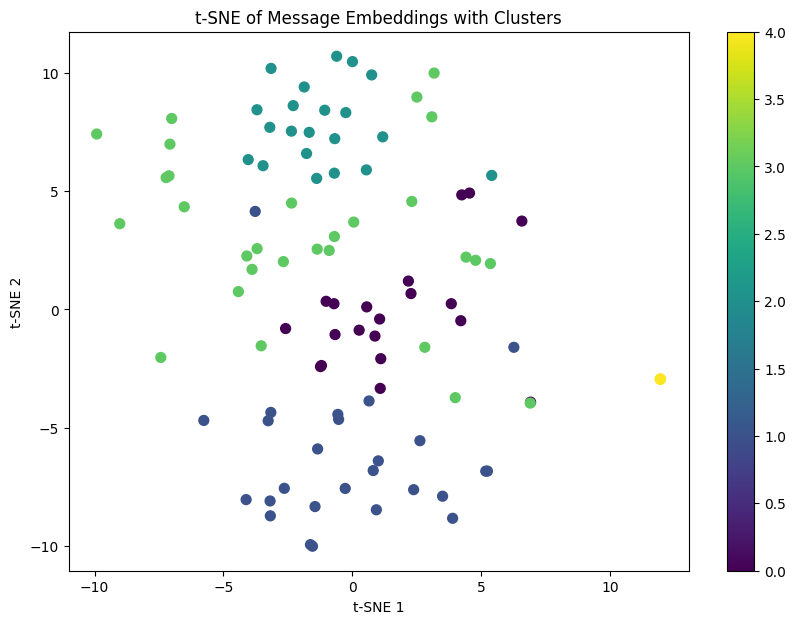

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd

# Function to plot the embeddings and clusters
def plot_embeddings_with_clusters(df, max_perplexity=30, n_iter=300):
    """
    Plots the 2D representation of the embeddings using t-SNE and colors based on clusters.
    
    Parameters:
    - df: DataFrame containing 'embedding' and 'cluster' columns.
    - max_perplexity: Maximum perplexity for t-SNE. Actual perplexity will be min(max_perplexity, n_samples-1).
    - n_iter: Number of iterations for t-SNE.
    """
    # Extract embeddings and cluster labels
    embeddings = np.array(df['embedding'].to_list())
    cluster_labels = df['cluster']

    # Set perplexity dynamically based on the number of samples
    n_samples = embeddings.shape[0]
    perplexity = min(max_perplexity, n_samples - 1)

    # Perform t-SNE to reduce embeddings to 2D
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plot the 2D embeddings
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis', s=50)
    
    # Add a colorbar for clusters
    plt.colorbar(scatter)
    
    plt.title("t-SNE of Message Embeddings with Clusters")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.show()

# Example of usage:
# Assuming `df` is your DataFrame with 'embedding' and 'cluster' columns
plot_embeddings_with_clusters(df2)


# Moving to Use Statictical Solutions

In [3]:
import pandas as pd
from typing import Optional, Dict, List
from pydantic import BaseModel
from openai_client import OpenAIClient
from tqdm import tqdm
import json

class TranslationResponse(BaseModel):
    """Response model for translations."""
    hebrew: str
    english: str

class MessageTranslator:
    """Processor class to handle Telegram message translation."""
    
    def __init__(self, client: OpenAIClient):
        self.client = client

    def translate_message(self, message: str) -> Optional[TranslationResponse]:
        """Translate a Telegram message into both Hebrew and English."""
        system_message = """
            Act as a highly accurate translator. Your task is to take an Arabic message from a Telegram group and translate it into both 
            Hebrew and English.

            Ensure that:
            
            - All emojis and decorative symbols (such as bullets, arrows, or icons) are removed from the original message before translation.
            - The translations are precise and maintain the original meaning, tone, and nuance, so the user fully understands both the context 
              and sentiment.
            - Military, organizational, or specific terminology (e.g., names of groups, military actions) should be translated consistently 
              without alteration or substitution.
            - Prioritize clarity and natural phrasing in both Hebrew and English, avoiding overly literal translations, while maintaining 
              fidelity to the original message.
            - Retain punctuation and formatting (such as parentheses) accurately to ensure readability in both languages.
            - Maintain urgency and emotional tone (e.g., in reports of military strikes, martyrdom) in a way that sounds natural and fluent.
        """
        
        response = self.client.chat(
            system_message=system_message,
            user_message=message,
            response_format=TranslationResponse,
            max_completion_tokens=3000
        )

        return response

class NERResponse(BaseModel):
    """Response model for Named Entity Recognition (NER)."""
    countries: List[str]
    locations: List[str]
    people: List[str]
    organizations: List[str]
    ad: bool
    
class NERProcessor:
    """Processor class to handle Named Entity Recognition (NER) on Telegram messages."""
    
    def __init__(self, client: OpenAIClient):
        self.client = client

    def extract_entities(self, message: str) -> Optional[NERResponse]:
        """Perform NER to extract locations, people, and organizations from the message."""
        system_message = """
            Act as an entity recognition system. Your task is to extract the following entities from the provided Arabic Telegram message:
            
            - Countries: Countries mentioned in the message.
            - Locations: Geographical places mentioned in the message.
            - People: Names of individuals mentioned.
            - Organizations: Names of groups, companies, or military organizations mentioned.
            - Ad: True when there is an ad for a Telegram chanel or to product.

            Ensure that:
            - You return only the names without extra context or symbols.
            - If no entities are found, return empty lists for each category.
        """
        
        response = self.client.chat(
            system_message=system_message,
            user_message=message,
            response_format=NERResponse,
            max_completion_tokens=3000
        )

        return response

class MainProcessor:
    """Class to manage the full pipeline: reading messages, translating, extracting entities, and updating DataFrame."""
    
    def __init__(self, translator: MessageTranslator, ner_processor: NERProcessor, df: pd.DataFrame):
        self.translator = translator
        self.ner_processor = ner_processor
        self.df = df.copy()  # Avoid modifying the original df

        # Prepare new columns for translations and entity recognition
        self.df['hebrew_translation'] = None
        self.df['english_translation'] = None
        self.df['locations'] = None
        self.df['people'] = None
        self.df['organizations'] = None

    def run(self) -> pd.DataFrame:
        """Run the full pipeline, translating each message, extracting entities, and returning an updated DataFrame."""
        for index, row in tqdm(self.df.iterrows(), total=len(self.df), desc="Processing messages"):
            message = row['message']
            
            # Perform translation
            translation = self.translator.translate_message(message)
            if translation:
                self.df.at[index, 'hebrew_translation'] = translation.hebrew
                self.df.at[index, 'english_translation'] = translation.english
            else:
                print(f"No translation found for message_id {row['message_id']}.")

            # Perform NER
            ner_data = self.ner_processor.extract_entities(translation.english)
            if ner_data:
                self.df.at[index, 'countries'] = ", ".join(ner_data.countries)
                self.df.at[index, 'locations'] = ", ".join(ner_data.locations)
                self.df.at[index, 'people'] = ", ".join(ner_data.people)
                self.df.at[index, 'organizations'] = ", ".join(ner_data.organizations)
                self.df.at[index, 'ad'] = float(ner_data.ad) if ner_data.ad != 'False' else np.nan
            else:
                print(f"No NER data found for message_id {row['message_id']}.")

        # Return the updated DataFrame with translations and NER data
        return self.df

if __name__ == "__main__":
    # Specify the file path
    file_path = "telegram_messages_v3.json"
    
    # Read the JSON file
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    # Convert the JSON data to a Pandas DataFrame
    df = pd.json_normalize(data)

    # Initialize the OpenAI client, translators, and processors
    openai_client = OpenAIClient()
    message_translator = MessageTranslator(openai_client)
    ner_processor = NERProcessor(openai_client)
    main_processor = MainProcessor(message_translator, ner_processor, df)

    # Run the pipeline and get the updated DataFrame
    updated_df = main_processor.run()

    # Print the total costs of OpenAI calls
    openai_client.print_total_costs()

    # Display the updated DataFrame with translations and entity recognition
    display(updated_df[['message', 'hebrew_translation', 'english_translation', 'countries' ,'locations', 'people', 'organizations', 'ad']])

Using closest match for encoding: 'gpt-4o' for input model 'gpt-4o-2024-08-06'
Resolved model for encoding: 'gpt-4o'
Using pricing model: 'gpt-4o-2024-08-06'


Processing messages: 100%|████████████████████████████████████████████████████| 100/100 [06:30<00:00,  3.91s/it]

Total prompt cost: $0.098900
Total completion cost: $0.116420
Overall total cost: $0.215320


,message,hebrew_translation,english_translation,countries,locations,people,organizations,ad
0,"📍‌‏بريطانيا: \nالعقوبات رد على ""الارتفاع في حد...","בריטניה: הסנקציות הן תגובה ל""עלייה ברמת האלימו...","Britain: The sanctions are a response to the ""...",Britain,West Bank,,,0.0
1,📍يديعوت أحرونوت: \nمقاتلون في وحدة أغوز تحدثوا...,ידיעות אחרונות: לוחמים ביחידת אגוז דיברו עם מפ...,Yedioth Ahronoth: Fighters in the Egoz unit ha...,,,,"Yedioth Ahronoth, Egoz",0.0
2,📍فيديو يُظهر الشهيد محمد دردونة من جباليا البل...,וידאו שמראה את השהיד מוחמד דרדונה מג'באליה אל-...,A video shows the martyr Muhammad Darduna from...,,"Jabalia al-Balad, Ashdod",Muhammad Darduna,,0.0
3,📍6 إصابات جرّاء قصف إسرائيلي استهدف نقطة شحن ج...,6 פצועים כתוצאה מהפצצה ישראלית שכוונה לנקודת ט...,6 injuries due to an Israeli strike targeting ...,"Israel, Palestine",Gaza,,,0.0
4,📍بطل عملية أسدود ، من غزة جباليا 🫡.,"גיבור הפעולה באשדוד, מג'בליה עזה.","The hero of the Ashdod operation, from Jabalia...",Gaza,"Ashdod, Jabalia",,,0.0
...,...,...,...,...,...,...,...,...
95,💢#عاجل| مصادر عبرية: ارتفاع عدد المصابين في عم...,מקורות עבריים: עלה מספר הפצועים בפיגוע ירי בכב...,Hebrew sources: The number of injured in the s...,Palestine,Road 4,,,0.0
96,💢المنفذ من فلسطيني الداخل داخل الاراضي المحتله,המחבל הוא פלסטיני מהפנים בתוך השטחים הכבושים.,The perpetrator is a Palestinian from within t...,,occupied territories,,,0.0
97,,כוחות הקרקע של האויב חזרו בשלום למוצבים שלהם ל...,Enemy ground forces have safely returned to th...,,,,,0.0
98,,התנגשויות חמורות מתרחשות בלילה בצפון עזה בין ה...,Severe clashes are occurring overnight in nort...,,northern Gaza,,"special forces, Palestinian armed groups",0.0


## GapEncoder

In [51]:
# Import necessary libraries
from skrub import GapEncoder
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Step 1: Enhanced text preprocessing
def preprocess_text(text):
    # Remove special characters and extra spaces
    cleaned = text.str.replace(r'[^a-zA-Z\s]', ' ', regex=True)
    # Convert to lowercase
    cleaned = cleaned.str.lower()
    # Remove extra whitespace
    cleaned = cleaned.str.replace(r'\s+', ' ', regex=True)
    # Strip leading/trailing whitespace
    cleaned = cleaned.str.strip()
    return cleaned

# Apply preprocessing
updated_df['cleaned_translation'] = preprocess_text(updated_df['english_translation'])

# Step 2: Create vocabulary using CountVectorizer
vectorizer = CountVectorizer(
    max_features=1000,
    stop_words='english'
)
vectorizer.fit(updated_df['cleaned_translation'])
vocabulary = vectorizer.get_feature_names_out()

# Step 3: Initialize and fit GapEncoder
n_components = 10
enc = GapEncoder(
    n_components=n_components,
    random_state=42
)

# Fit and transform on the cleaned text Series
encoded_vectors = enc.fit_transform(updated_df['cleaned_translation'])

# Step 4: Get dominant topics
dominant_topic_indices = np.argmax(encoded_vectors, axis=1) + 1
updated_df['Dominant_Topic_Num'] = dominant_topic_indices

# Step 5: Extract words for topics using vectorizer vocabulary
def get_top_words_for_topic(docs_in_topic):
    # Combine all documents in the topic
    topic_text = ' '.join(docs_in_topic)
    
    # Get word frequencies
    word_counts = vectorizer.transform([topic_text]).toarray()[0]
    word_freq = list(zip(vocabulary, word_counts))
    
    # Sort by frequency
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
    
    # Return top words (excluding very short words)
    top_words = [word for word, freq in word_freq if len(word) > 2][:10]
    return top_words

# Get keywords for each topic
topic_keywords = []
for topic_num in range(1, n_components + 1):
    topic_docs = updated_df[updated_df['Dominant_Topic_Num'] == topic_num]['cleaned_translation']
    topic_keywords.append(get_top_words_for_topic(topic_docs))

# Step 6: Print results
topic_counts = updated_df['Dominant_Topic_Num'].value_counts().sort_index()

# Calculate average normalized score per topic and find top messages
topic_avg_scores = {}
topic_top_messages = {}
for topic_num in range(1, n_components + 1):
    if isinstance(encoded_vectors, np.ndarray):
        topic_scores = encoded_vectors[:, topic_num-1]
    elif isinstance(encoded_vectors, pd.DataFrame):
        topic_scores = encoded_vectors.iloc[:, topic_num-1]
    else:
        raise TypeError("encoded_vectors must be a numpy array or pandas DataFrame")
    
    topic_mask = updated_df['Dominant_Topic_Num'] == topic_num
    topic_avg_scores[topic_num] = topic_scores[topic_mask].mean()
    
    # Get top 3 messages for this topic
    top_indices = topic_scores[topic_mask].nlargest(3).index
    topic_top_messages[topic_num] = [
        (updated_df.loc[idx, 'english_translation'], topic_scores[idx])
        for idx in top_indices
    ]

# Normalize the average scores
max_score = max(topic_avg_scores.values())
min_score = min(topic_avg_scores.values())
normalized_scores = {k: (v - min_score) / (max_score - min_score) for k, v in topic_avg_scores.items()}

print("\nMessage counts, coherence scores, and top messages per topic:")
for topic_num, count in topic_counts.items():
    print(f"\nTopic {topic_num}: {count} messages")
    print(f"Keywords: {', '.join(topic_keywords[topic_num-1])}")
    print(f"Normalized coherence score: {normalized_scores[topic_num]:.4f}")
    print("Top 3 most coherent messages:")
    for i, (msg, score) in enumerate(topic_top_messages[topic_num], 1):
        # Remove line breaks and truncate to 100 characters
        truncated_msg = ' '.join(msg.split())[:1000]
        if len(truncated_msg) == 100:
            truncated_msg += '...'
        print(f"{i}. (Score: {score:.4f}) {truncated_msg}")
    print("-" * 80)


Message counts, coherence scores, and top messages per topic:

Topic 1: 6 messages
Keywords: hezbollah, rocket, barrage, fighters, haifa, lebanon, amid, city, face, launched
Normalized coherence score: 0.0293
Top 3 most coherent messages:
1. (Score: 209.6443) Walla site: - Increased complaints and fear among Israelis in Haifa due to the shortage of shelters amid rising rocket attacks. - The tourism movement in the city of Haifa has suffered a severe blow amid continued rocket barrages from Lebanon.
2. (Score: 130.2277) Hezbollah: "Our fighters have launched a large rocket barrage at the occupied city of Haifa."
3. (Score: 122.9037) Hezbollah: "Our fighters targeted a gathering of soldiers and vehicles of the Israeli occupation army in Khala Warda with a barrage of rockets."
--------------------------------------------------------------------------------

Topic 2: 2 messages
Keywords: deputy, general, hezbollah, secretary, urgent, israel, lebanon, support, occupation, palestinians
Norm

## LDA

In [54]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Step 1: Enhanced text preprocessing (unchanged)
def preprocess_text(text):
    # Remove special characters and extra spaces
    cleaned = text.str.replace(r'[^a-zA-Z\s]', ' ', regex=True)
    # Convert to lowercase
    cleaned = cleaned.str.lower()
    # Remove extra whitespace
    cleaned = cleaned.str.replace(r'\s+', ' ', regex=True)
    # Strip leading/trailing whitespace
    cleaned = cleaned.str.strip()
    return cleaned

# Apply preprocessing
updated_df['cleaned_translation'] = preprocess_text(updated_df['english_translation'])

# Step 2: Create vocabulary and document-term matrix using CountVectorizer
vectorizer = CountVectorizer(
    max_features=1000,
    stop_words='english'
)
doc_term_matrix = vectorizer.fit_transform(updated_df['cleaned_translation'])
vocabulary = vectorizer.get_feature_names_out()

# Step 3: Initialize and fit LDA
n_components = 10
lda_model = LatentDirichletAllocation(
    n_components=n_components,
    random_state=42
)
lda_output = lda_model.fit_transform(doc_term_matrix)

# Step 4: Get dominant topics
dominant_topic_indices = np.argmax(lda_output, axis=1) + 1
updated_df['Dominant_Topic_Num'] = dominant_topic_indices

# Step 5: Extract words for topics
def get_top_words_for_topic(topic_idx, n_top_words=10):
    topic_words = lda_model.components_[topic_idx]
    top_word_indices = topic_words.argsort()[:-n_top_words-1:-1]
    return [vocabulary[i] for i in top_word_indices]

# Get keywords for each topic
topic_keywords = [get_top_words_for_topic(i) for i in range(n_components)]

# Step 6: Print results
topic_counts = updated_df['Dominant_Topic_Num'].value_counts().sort_index()

# Calculate average normalized score per topic and find top messages
topic_avg_scores = {}
topic_top_messages = {}
for topic_num in range(1, n_components + 1):
    topic_scores = lda_output[:, topic_num-1]
    topic_mask = updated_df['Dominant_Topic_Num'] == topic_num
    topic_avg_scores[topic_num] = topic_scores[topic_mask].mean()
    
    # Get top 3 messages for this topic
    top_indices = topic_scores[topic_mask].argsort()[-3:][::-1]
    topic_top_messages[topic_num] = [
        (updated_df.loc[updated_df[topic_mask].index[i], 'english_translation'], topic_scores[topic_mask][i])
        for i in top_indices
    ]

# Normalize the average scores
max_score = max(topic_avg_scores.values())
min_score = min(topic_avg_scores.values())
normalized_scores = {k: (v - min_score) / (max_score - min_score) for k, v in topic_avg_scores.items()}

print("\nMessage counts, coherence scores, and top messages per topic:")
for topic_num, count in topic_counts.items():
    print(f"\nTopic {topic_num}: {count} messages")
    print(f"Keywords: {', '.join(topic_keywords[topic_num-1])}")
    print(f"Normalized coherence score: {normalized_scores[topic_num]:.4f}")
    print("Top 3 most coherent messages:")
    for i, (msg, score) in enumerate(topic_top_messages[topic_num], 1):
        # Remove line breaks and truncate to 1000 characters
        truncated_msg = ' '.join(msg.split())[:1000]
        if len(truncated_msg) == 1000:
            truncated_msg += '...'
        print(f"{i}. (Score: {score:.4f}) {truncated_msg}")
    print("-" * 80)


Message counts, coherence scores, and top messages per topic:

Topic 1: 7 messages
Keywords: deputy, secretary, general, hezbollah, urgent, israel, palestine, occupation, resistance, lebanon
Normalized coherence score: 1.0000
Top 3 most coherent messages:
1. (Score: 0.9940) Urgent | Deputy Secretary General of Hezbollah: Israel and those behind it are fighting and committing massacres, and we are in a situation that requires us to take a stance Urgent | Deputy Secretary General of Hezbollah: Our hope for victory knows no bounds Urgent | Deputy Secretary General of Hezbollah: Israel is an occupying entity that poses a real danger to the region and the world Urgent | Deputy Secretary General of Hezbollah: Israel is an occupying entity founded on killing and displacement Urgent | Deputy Secretary General of Hezbollah: Israel relies on crime that terrifies others and the absolute support from America and time Urgent | Deputy Secretary General of Hezbollah: Palestinians have the right to u

## BERTopic

In [72]:
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from nltk.corpus import stopwords
import nltk
from umap import UMAP
from hdbscan import HDBSCAN
import random
import torch

# Download stopwords if not already downloaded
nltk.download('stopwords', quiet=True)

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Assuming updated_df is your DataFrame with the 'english_translation' column

# Step 1: Remove stopwords (create a temporary column)
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

temp_text = updated_df['english_translation'].apply(remove_stopwords)

# Initialize BERTopic with specific number of topics and keywords
topic_model = BERTopic(
    language="english", 
    calculate_probabilities=True,
    verbose=True,
    nr_topics=10,
    top_n_words=10,
    umap_model=UMAP(
        n_neighbors=15, 
        n_components=10, 
        min_dist=0.0, 
        metric='cosine', 
        random_state=RANDOM_SEED
    ),
    hdbscan_model=HDBSCAN(
        min_cluster_size=5, 
        metric='euclidean', 
        cluster_selection_method='eom', 
        prediction_data=True
    )
)

# Fit the model and transform the documents
topics, probs = topic_model.fit_transform(temp_text)

# Add the topic numbers to the DataFrame
updated_df['Dominant_Topic_Num'] = topics

# Get topic information
topic_info = topic_model.get_topic_info()

# Calculate normalized coherence scores
coherence_scores = topic_model.topic_embeddings_.mean(axis=1)
normalized_scores = (coherence_scores - coherence_scores.min()) / (coherence_scores.max() - coherence_scores.min())

print("\nMessage counts, coherence scores, and top messages per topic:")
for topic_num in range(len(topic_info) - 1):  # Exclude the -1 topic
    topic_messages = updated_df[updated_df['Dominant_Topic_Num'] == topic_num]
    count = len(topic_messages)
    
    print(f"\nTopic {topic_num}: {count} messages")
    
    # Get keywords
    try:
        keywords = ", ".join([word for word, _ in topic_model.get_topic(topic_num)])
    except TypeError:
        keywords = "No keywords available for this topic"
    print(f"Keywords: {keywords}")
    
    # Print normalized coherence score
    if topic_num < len(normalized_scores):
        print(f"Normalized coherence score: {normalized_scores[topic_num]:.4f}")
    else:
        print("Normalized coherence score: Not available")
    
    if count > 0:
        # Get top 5 messages
        topic_probs = probs[:, topic_num]
        top_5_indices = topic_probs.argsort()[-5:][::-1]
        print("Top 5 most representative messages:")
        for i, idx in enumerate(top_5_indices, 1):
            if updated_df.index[idx] in topic_messages.index:
                msg = updated_df.loc[updated_df.index[idx], 'english_translation']
                score = topic_probs[idx]
                truncated_msg = ' '.join(msg.split())[:200]  # Truncate to 200 characters
                if len(truncated_msg) == 200:
                    truncated_msg += '...'
                print(f"{i}. (Score: {score:.4f}) {truncated_msg}")
    else:
        print("No messages in this topic")
    
    print("-" * 80)

# Print outliers
print("\nOutlier Documents:")
outliers = updated_df[updated_df['Dominant_Topic_Num'] == -1]
for idx, row in outliers.iterrows():
    closest_topic = np.argmax(probs[idx])
    closest_score = probs[idx, closest_topic]
    truncated_msg = ' '.join(row['english_translation'].split())[:200]
    if len(truncated_msg) == 200:
        truncated_msg += '...'
    print(f"Document: {truncated_msg}")
    print(f"Closest Topic: {closest_topic}, Score: {closest_score:.4f}")
    print("-" * 80)

# Print overall model evaluation
print("\nTopic Model Summary:")
print(f"Number of topics: {len(topic_info) - 1}")  # Subtract 1 to exclude the -1 topic
print(f"Total documents: {len(updated_df)}")
print(f"Documents in topics: {len(updated_df[updated_df['Dominant_Topic_Num'] != -1])}")
print(f"Outlier documents: {len(updated_df[updated_df['Dominant_Topic_Num'] == -1])}")


2024-10-17 03:47:54,076 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2024-10-17 03:47:55,947 - BERTopic - Embedding - Completed ✓
2024-10-17 03:47:55,947 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-10-17 03:47:56,515 - BERTopic - Dimensionality - Completed ✓
2024-10-17 03:47:56,516 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-10-17 03:47:56,522 - BERTopic - Cluster - Completed ✓
2024-10-17 03:47:56,523 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-10-17 03:47:56,531 - BERTopic - Representation - Completed ✓
2024-10-17 03:47:56,532 - BERTopic - Topic reduction - Reducing number of topics
2024-10-17 03:47:56,533 - BERTopic - Topic reduction - Reduced number of topics from 5 to 5



Message counts, coherence scores, and top messages per topic:

Topic 0: 15 messages
Keywords: hebron, occupation, forces, yatta, town, prisoner, prisons, city, south, sair
Normalized coherence score: 0.6112
Top 5 most representative messages:
1. (Score: 1.0000) Urgent Injury by gunfire from the occupation forces in the town of Sa'ir, northeast of Hebron.
2. (Score: 1.0000) Moving The meeting of the released prisoner Ahmad Al-Awiwi with his family in the city of Hebron, after a year in the prisons of the occupation.
3. (Score: 1.0000) The occupation forces are entrenched at the Hamran triangle in the town of Sa'ir, north of Hebron.
4. (Score: 1.0000) The occupation releases the prisoner Mohammad Fawaz Yadak from the village of Qusin in Nablus after 20 years in the occupation's prisons.
5. (Score: 1.0000) The security campaign of the Israeli occupation in the city of Yatta, south of Hebron, has been ongoing for more than 8 hours, with several houses being used as military barracks.
----

Seeing topic number 2, which was about the shooting in Ashdod:

In [73]:
topic_num = 2

print(f"\nDetails for Topic {topic_num}:")

# Get topic messages
topic_messages = updated_df[updated_df['Dominant_Topic_Num'] == topic_num]
count = len(topic_messages)

print(f"Number of messages: {count}")

# Get keywords
keywords = ", ".join([word for word, _ in topic_model.get_topic(topic_num)])
print(f"Keywords: {keywords}")

# Print normalized coherence score
print(f"Normalized coherence score: {normalized_scores[topic_num]:.4f}")

if count > 0:
    # Get top 5 messages
    topic_probs = topic_model.probabilities_[:, topic_num]
    top_5_indices = topic_probs.argsort()[-5:][::-1]
    print("\nTop 5 most representative messages:")
    for i, idx in enumerate(top_5_indices, 1):
        if updated_df.index[idx] in topic_messages.index:
            msg = updated_df.loc[updated_df.index[idx], 'english_translation']
            score = topic_probs[idx]
            truncated_msg = ' '.join(msg.split())[:200]  # Truncate to 200 characters
            if len(truncated_msg) == 200:
                truncated_msg += '...'
            print(f"{i}. (Score: {score:.4f}) {truncated_msg}")
else:
    print("No messages in this topic")

print("-" * 80)


Details for Topic 2:
Number of messages: 17
Keywords: ashdod, shooting, operation, police, near, channel, attack, injured, killed, officer
Normalized coherence score: 0.3177

Top 5 most representative messages:
1. (Score: 1.0000) A video shows the perpetrator of the Ashdod operation before its execution, which resulted in the killing of an occupation forces officer and the wounding of four others with varying injuries.
2. (Score: 1.0000) Updated results of the Ashdod operation: 1 dead, 1 moderately injured, 3 lightly injured.
3. (Score: 1.0000) From the scene of the shooting operation on Street No. 4 in Ashdod.
4. (Score: 1.0000) Closure of Route 4 in Ashdod to vehicles following a shooting attack at the location.
5. (Score: 1.0000) A video shows the martyr Muhammad Darduna from Jabalia al-Balad, as he set out to carry out a shooting operation in occupied Ashdod, resulting in the death of one occupation police officer and 4 injur...
----------------------------------------------------

# For Later...

I used GPT for extracting the topics names of the keywords that were extracted: https://chatgpt.com/share/67103318-bdbc-800a-803b-8699aefb4433

In [172]:
topics = {
    1: "Missile Strikes and Air Defense",
    2: "Geopolitical Tensions and Hezbollah-Lebanon Relations",
    3: "Attacks on Security Forces and Law Enforcement",
    4: "Violent Clashes and Armed Incursions",
    5: "Resistance and Defensive Capabilities",
    6: "Rocket Attacks and Targeted Settlements",
    7: "International Relations and Arms Supplies",
    8: "Occupation and Military Operations in Palestinian Territories",
    9: "Northern Border and Civilian Alerts",
    10: "Casualties and Military Operations in Southern Areas"
}

# To print the topics
for topic_num, topic_name in topics.items():
    print(f"Topic {topic_num}: {topic_name}")

Topic 1: Missile Strikes and Air Defense
Topic 2: Geopolitical Tensions and Hezbollah-Lebanon Relations
Topic 3: Attacks on Security Forces and Law Enforcement
Topic 4: Violent Clashes and Armed Incursions
Topic 5: Resistance and Defensive Capabilities
Topic 6: Rocket Attacks and Targeted Settlements
Topic 7: International Relations and Arms Supplies
Topic 8: Occupation and Military Operations in Palestinian Territories
Topic 9: Northern Border and Civilian Alerts
Topic 10: Casualties and Military Operations in Southern Areas


In [ ]:
dominant_topic_descriptions = [topics[topic_num] for topic_num in dominant_topic_indices]


/tmp/ipykernel_17515/2275353815.py:15: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


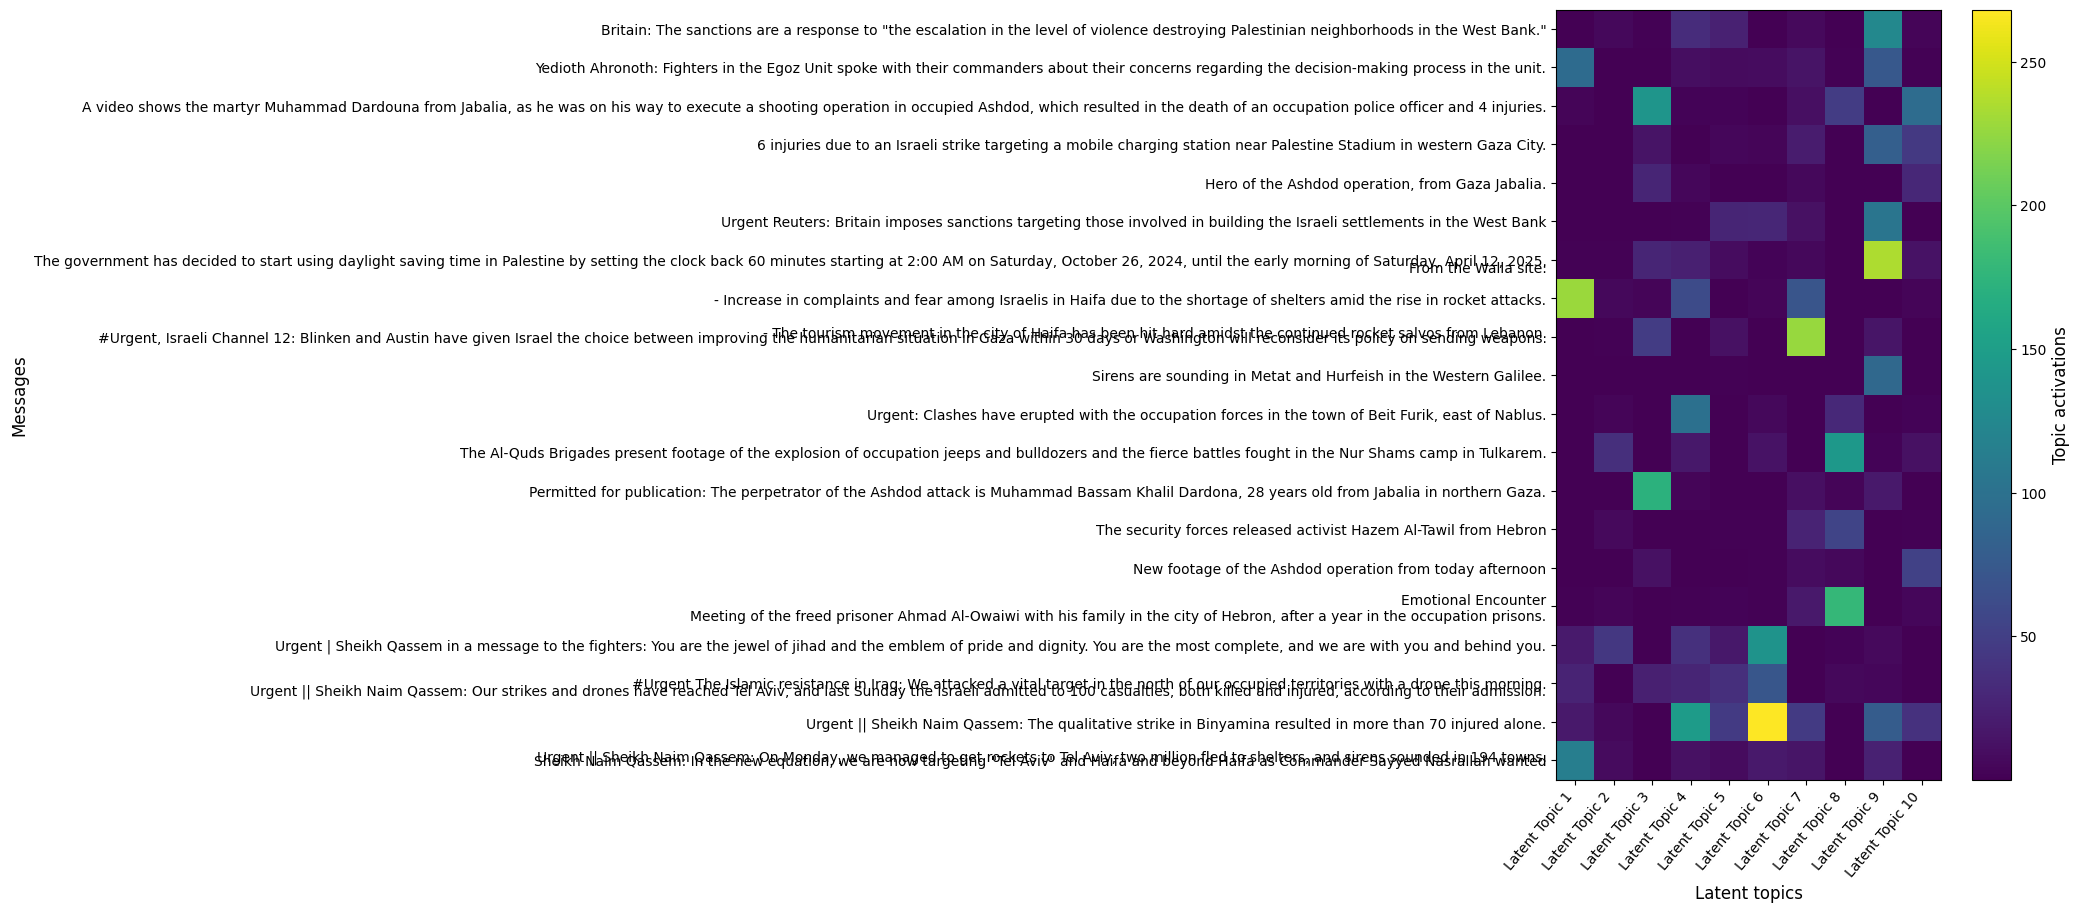

In [173]:
# Continue from the previous code, now let's visualize the encoded vectors and interpret them
import matplotlib.pyplot as plt

# Transform the first 20 messages for visualization
encoded_vectors = enc.transform(messages_series[:20])

# Create a plot for the encoded vectors
plt.figure(figsize=(8, 10))
plt.imshow(encoded_vectors)  # Heatmap of the encoded vectors
plt.xlabel("Latent topics", size=12)
plt.xticks(range(0, n_components), labels=[f"Latent Topic {i+1}" for i in range(n_components)], rotation=50, ha="right")
plt.ylabel("Messages", size=12)
plt.yticks(range(0, 20), labels=messages_series[:20].to_numpy().flatten())
plt.colorbar().set_label(label="Topic activations", size=12)
plt.tight_layout()
plt.show()

Latent Topic #1: sunglasses, enhances, indoors
Latent Topic #2: actually, breaking, observe
Latent Topic #3: preparing, explode, country
Latent Topic #4: technology, announces, discovery
Latent Topic #5: governments, government, travel
Latent Topic #6: citizens, mandatory, build
Latent Topic #7: legislation, elections, according
Latent Topic #8: astronauts, stronger, smartphones
Latent Topic #9: mysterious, shrinking, drinking
Latent Topic #10: classified, superfood, capable


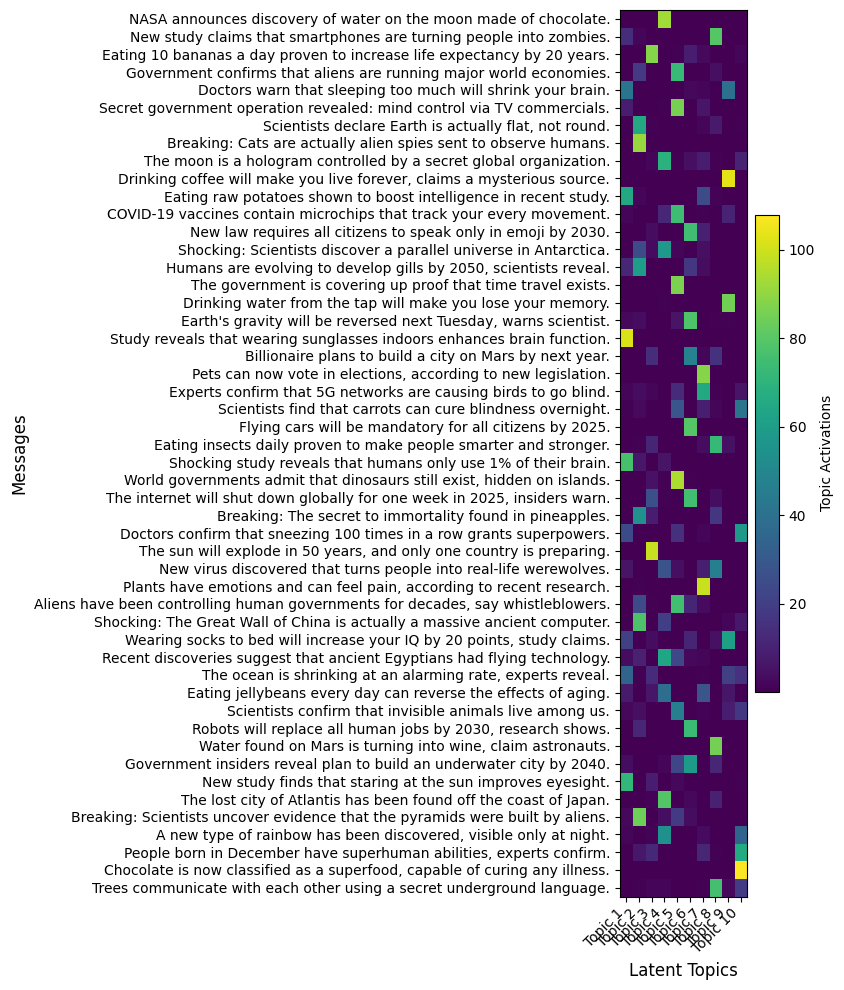

In [163]:
# Step 1: Convert the list of messages into a pandas Series
messages_series = pd.Series(messages)

# Step 2: Initialize GapEncoder with a chosen number of components (latent topics)
n_components = 10  # You can adjust this based on how many latent topics you want
enc = GapEncoder(n_components=n_components, random_state=42)

# Step 3: Fit the encoder on the pandas Series of messages
enc.fit(messages_series)

# Step 4: Transform the messages into encoded vectors
encoded_vectors = enc.transform(messages_series)

# Step 5: Get feature names (latent topics) and print them out
# We'll ask the encoder to provide the top 3 most representative labels for each latent topic
n_labels = 3  # You can adjust this to get more or fewer labels per topic
topic_labels = enc.get_feature_names_out(n_labels=n_labels)

# Print the feature names (latent topics)
for k, labels in enumerate(topic_labels):
    print(f"Latent Topic #{k+1}: {labels}")

# Step 6: Plot the encoding and the interpretation of each message for the latent topics
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 10))
plt.imshow(encoded_vectors, aspect='auto', cmap='viridis')
plt.xlabel("Latent Topics", size=12)
plt.xticks(ticks=np.arange(n_components), labels=[f"Topic {i+1}" for i in range(n_components)], rotation=45, ha="right")
plt.ylabel("Messages", size=12)
plt.yticks(ticks=np.arange(len(messages)), labels=messages)
plt.colorbar(label="Topic Activations")
plt.tight_layout()
plt.show()
